In [53]:
print('\033[32mJUNXUN\033[0m')

JUNXUN


In [2]:
import sys
print(sys.executable)
print(sys.version)
print(sys.version_info)

D:\anaconda\python.exe
3.9.13 (main, Aug 25 2022, 23:51:50) [MSC v.1916 64 bit (AMD64)]
sys.version_info(major=3, minor=9, micro=13, releaselevel='final', serial=0)


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import pytz
import datetime
try:
    import talib
    import ccxt
except ImportError:
    ! conda install -c conda-forge ta-lib
    ! pip install ccxt
    import talib
    import ccxt
import time

pd.set_option('display.max_rows', 5000)
pd.set_option('expand_frame_repr', False)

In [2]:
currency_lst = ['ETH/USDT', 'DOGE/USDT', 'SOL/USDT', 'FIL/USDT', 'LTC/USDT', 'BNB/USDT', 'SHIB/USDT', 'XRP/USDT', 'AAVE/USDT', ]

In [3]:
# create the exchange object
exchange = ccxt.binance()
# set the timeframe to 1 minute
timeframe = '30m'
# set the start time to 1 month before
start_time = int(datetime.datetime.strptime("2022-01-01 00:00:00", "%Y-%m-%d %H:%M:%S").timestamp() * 1000)
# set the end time to the current time
end_time = int(datetime.datetime.strptime("2023-01-01 00:00:00", "%Y-%m-%d %H:%M:%S").timestamp() * 1000)
# set the number of data points to fetch per API request
limit = 1000

In [4]:
# create an empty dataframe to hold the results
df_btc = pd.DataFrame()

In [5]:
# loop through the time range and fetch data
while start_time < end_time:
    # fetch the OHLCV data
    ohlcv_btc = exchange.fetch_ohlcv('BTC/USDT', timeframe, since=start_time, limit=limit)
    # convert the data to a pandas dataframe
    df = pd.DataFrame(ohlcv_btc, columns=['timestamp', 'open', 'high', 'low', 'BTC_close', 'BTC_volume'])
    # append the data to the main dataframe
    df_btc = pd.concat([df_btc, df])
    # set the start time for the next request
    start_time = int(df['timestamp'].iloc[-1]) + 60 * 1000

In [6]:
# convert the timestamp to datetime format and set timezone Toronto time
df_btc['timestamp'] = pd.to_datetime(df_btc['timestamp'], unit='ms').dt.tz_localize('UTC').dt.tz_convert('America/Toronto').dt.strftime('%Y-%m-%d %H:%M:%S')

In [7]:
# set the timestamp as the index
df_btc.set_index('timestamp', inplace=True)

In [8]:
# get close price and volume for BTC
df_btc_px = df_btc['BTC_close']
df_btc_vol = df_btc['BTC_volume']
df = pd.merge(df_btc_px, df_btc_vol, on='timestamp')

In [9]:
df

,BTC_close,BTC_volume
timestamp,,
2022-01-01 00:00:00,47379.13,793.08192
2022-01-01 00:30:00,47192.55,607.65450
2022-01-01 01:00:00,47130.36,267.90481
2022-01-01 01:30:00,46979.62,346.07295
2022-01-01 02:00:00,46959.61,295.25750
...,...,...
2023-01-10 21:30:00,17388.20,4010.98004
2023-01-10 22:00:00,17410.69,4549.10986
2023-01-10 22:30:00,17416.14,2853.62609


#### Get data for rest 9 cryptos, please wait for API to fetch data, it may takes 2 minutes to get 10 cryptos data. This is because when request data from binance, it only gives 1000 data once (OKX is 100). Should use while loop to get full data.

In [10]:
for crypto in currency_lst:
    cur = crypto[:-5]
    close = cur + '_close'
    volume = cur + '_volume'
    start_time = int(datetime.datetime.strptime("2022-01-01 00:00:00", "%Y-%m-%d %H:%M:%S").timestamp() * 1000)
    df_crypto = pd.DataFrame()
    while start_time < end_time:
        # fetch the OHLCV data
        ohlcv_temp = exchange.fetch_ohlcv(crypto, timeframe, since=start_time, limit=limit)
        # convert the data to a pandas dataframe
        df_temp = pd.DataFrame(ohlcv_temp, columns=['timestamp', 'open', 'high', 'low', close, volume])
        # append the data to the main dataframe
        df_crypto = pd.concat([df_crypto, df_temp])
        # set the start time for the next request
        start_time = int(df_temp['timestamp'].iloc[-1]) + 60 * 1000
    df_crypto['timestamp'] = pd.to_datetime(df_crypto['timestamp'], unit='ms').dt.tz_localize('UTC').dt.tz_convert('America/Toronto').dt.strftime('%Y-%m-%d %H:%M:%S')
    # set the timestamp as the index
    df_crypto.set_index('timestamp', inplace=True)
    df_crypto_px = df_crypto[close]
    df_crypto_vol = df_crypto[volume]
    df_merge = pd.merge(df_crypto_px, df_crypto_vol, on='timestamp')
    df = pd.merge(df, df_merge, on='timestamp')

In [12]:
# Use exactly 1 moth data
df = df.loc['2022-01-01 00:00:00':'2023-01-01 00:00:00']

In [13]:
df.to_csv("binance_1m_data.csv", index=True)

### If you have the data "binance_1m_data.csv" locally, start from here

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import pytz
import datetime
try:
    import talib
    import ccxt
except ImportError:
    ! conda install -c conda-forge ta-lib
    ! pip install ccxt
    import talib
    import ccxt
import time

pd.set_option('display.max_rows', 5000)
pd.set_option('expand_frame_repr', False)

In [2]:
df = pd.read_csv('binance_1m_data.csv', index_col='timestamp', parse_dates=True)

In [3]:
df.head()

,BTC_close,BTC_volume,ETH_close,ETH_volume,DOGE_close,DOGE_volume,SOL_close,SOL_volume,FIL_close,FIL_volume,LTC_close,LTC_volume,BNB_close,BNB_volume,SHIB_close,SHIB_volume,XRP_close,XRP_volume,AAVE_close,AAVE_volume
timestamp,,,,,,,,,,,,,,,,,,,,
2022-01-01 00:00:00,47379.13,793.08192,3750.69,5929.8941,0.1720,13752546.0,173.71,15366.34,34.84,66770.35,148.8,6934.841,520.3,12504.491,0.000034,7.312235e+10,0.8439,3060673.0,262.9,2787.897
2022-01-01 00:30:00,47192.55,607.65450,3735.61,3423.3115,0.1717,6722588.0,173.26,13494.15,34.77,57637.66,148.1,7045.217,518.0,10650.522,0.000034,7.080380e+10,0.8421,3106081.0,261.3,3476.485
2022-01-01 01:00:00,47130.36,267.90481,3727.65,2674.4177,0.1716,2736656.0,172.61,16990.42,34.79,23737.43,147.7,3747.091,516.3,14248.945,0.000034,8.492489e+10,0.8415,2017950.0,260.8,1057.201
2022-01-01 01:30:00,46979.62,346.07295,3711.92,2564.5849,0.1711,5697811.0,172.45,13714.25,34.62,28214.49,147.1,5129.352,515.1,8228.759,0.000034,5.998779e+10,0.8377,7761027.0,259.2,1126.356
2022-01-01 02:00:00,46959.61,295.25750,3707.96,3287.8317,0.1710,4065516.0,172.40,7702.92,34.69,29227.32,147.2,7548.368,513.8,11165.965,0.000034,6.331962e+10,0.8382,2493952.0,258.4,1561.486


Extract columns to form the returns dataset and the volumes dataset

In [4]:
columns = list(df.columns)
i = 0
ret_index_list = []
vol_index_list = []
while i < len(columns):
    ret_index_list.append(i)
    i += 1
    vol_index_list.append(i)
    i += 1
df_returns = df.iloc[:, ret_index_list]
df_volumes = df.iloc[:, vol_index_list]

In [5]:
# get the half-hour returns and volumes
df_returns = df_returns.resample('30T', level='timestamp').last()
df_returns = df_returns.pct_change()
df_volumes = df_volumes.resample('30T', level='timestamp').sum()
# remove first nan row
df_returns = df_returns.iloc[1:]

In [6]:
# rename columns
new_names = {col: col.replace("_close", "_return") for col in df_returns.columns}
df_returns = df_returns.rename(columns=new_names)
df_returns.head()

,BTC_return,ETH_return,DOGE_return,SOL_return,FIL_return,LTC_return,BNB_return,SHIB_return,XRP_return,AAVE_return
timestamp,,,,,,,,,,
2022-01-01 00:30:00,-0.003938,-0.004021,-0.001744,-0.002591,-0.002009,-0.004704,-0.004421,-0.002073,-0.002133,-0.006086
2022-01-01 01:00:00,-0.001318,-0.002131,-0.000582,-0.003752,0.000575,-0.002701,-0.003282,0.001187,-0.000713,-0.001914
2022-01-01 01:30:00,-0.003198,-0.004220,-0.002914,-0.000927,-0.004886,-0.004062,-0.002324,-0.001482,-0.004516,-0.006135
2022-01-01 02:00:00,-0.000426,-0.001067,-0.000584,-0.000290,0.002022,0.000680,-0.002524,0.000594,0.000597,-0.003086
2022-01-01 02:30:00,0.005007,0.001982,0.001754,0.004118,0.004036,0.005435,0.003893,0.002077,0.003579,0.001548


In [7]:
df_volumes.head()

,BTC_volume,ETH_volume,DOGE_volume,SOL_volume,FIL_volume,LTC_volume,BNB_volume,SHIB_volume,XRP_volume,AAVE_volume
timestamp,,,,,,,,,,
2022-01-01 00:00:00,793.08192,5929.8941,13752546.0,15366.34,66770.35,6934.841,12504.491,7.312235e+10,3060673.0,2787.897
2022-01-01 00:30:00,607.65450,3423.3115,6722588.0,13494.15,57637.66,7045.217,10650.522,7.080380e+10,3106081.0,3476.485
2022-01-01 01:00:00,267.90481,2674.4177,2736656.0,16990.42,23737.43,3747.091,14248.945,8.492489e+10,2017950.0,1057.201
2022-01-01 01:30:00,346.07295,2564.5849,5697811.0,13714.25,28214.49,5129.352,8228.759,5.998779e+10,7761027.0,1126.356
2022-01-01 02:00:00,295.25750,3287.8317,4065516.0,7702.92,29227.32,7548.368,11165.965,6.331962e+10,2493952.0,1561.486


#### Run cross-sectional regression for returns, r (t-k), k = half-hour index

In [17]:
import re
import statsmodels.api as sm
import statsmodels.formula.api as smf
import warnings
warnings.filterwarnings("ignore")

In [71]:
df_returns.shape

(17520, 10)

In [72]:
df_returns.head()

,BTC_return,ETH_return,DOGE_return,SOL_return,FIL_return,LTC_return,BNB_return,SHIB_return,XRP_return,AAVE_return
timestamp,,,,,,,,,,
2022-01-01 00:30:00,-0.003938,-0.004021,-0.001744,-0.002591,-0.002009,-0.004704,-0.004421,-0.002073,-0.002133,-0.006086
2022-01-01 01:00:00,-0.001318,-0.002131,-0.000582,-0.003752,0.000575,-0.002701,-0.003282,0.001187,-0.000713,-0.001914
2022-01-01 01:30:00,-0.003198,-0.004220,-0.002914,-0.000927,-0.004886,-0.004062,-0.002324,-0.001482,-0.004516,-0.006135
2022-01-01 02:00:00,-0.000426,-0.001067,-0.000584,-0.000290,0.002022,0.000680,-0.002524,0.000594,0.000597,-0.003086
2022-01-01 02:30:00,0.005007,0.001982,0.001754,0.004118,0.004036,0.005435,0.003893,0.002077,0.003579,0.001548


#### Run regression for **Bitcoin**

Get lagk data for every day, k = 0 ... 480

In [495]:
# shift k lags
df_returns['BTC_ret_lag1'] = df_returns['BTC_return'].shift()
df_btc_ret = df_returns[['BTC_return', 'BTC_ret_lag1']]
df_btc_ret.rename(columns={'BTC_return': 'BTC_ret_lag0'}, inplace=True)
for i in range(2, 1441):
    lag = "BTC_ret_lag" + str(i)
    df_btc_ret[lag] = df_returns['BTC_return'].shift(i)

In [496]:
# reverse dataset for better understandding of lags
df_btc_ret_r = df_btc_ret.iloc[::-1]

In [497]:
# remove missing data
df_btc_ret_r = df_btc_ret_r.dropna()

In [591]:
# Specify the dependent and independent variables
# dependent variable: lastest returns k = 0
# independent variables: lag returns k, k = 1 ... 1440
lag_cols = list(df_btc_ret_r.columns)
y = df_btc_ret_r[lag_cols.pop(0)]
X = df_btc_ret_r[lag_cols]
X = sm.add_constant(X) 
# Run the regression
BTC_lag1440_ret_reg = sm.OLS(y, X).fit()

Plot Bitcoin return estimates of cross-sectional regressions

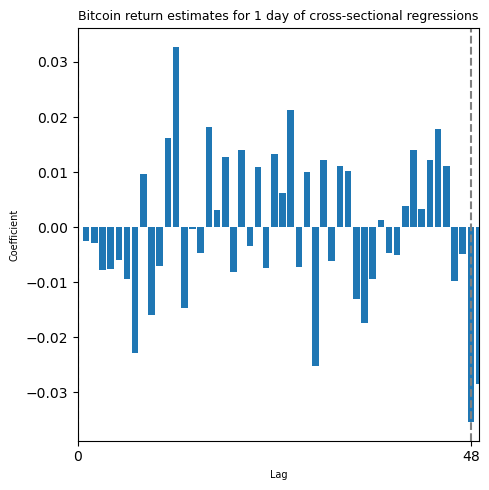

In [524]:
# Extract coefficients
coef_btc = BTC_lag1440_ret_reg.params
# Delete intercept coef
gamma = np.delete(coef_btc.values, 0)
gamma = np.insert(np.array(gamma), 0, 0)
lags = np.delete(coef_btc.index, 0)
lags = np.array([int(re.findall('\d+', lag)[0]) for lag in lags])
lags = np.insert(lags, 0, 0)
# Create a bar plot
gamma = gamma[:337]
lags = lags[:337]
fig, ax = plt.subplots(figsize=(24, 8))
ax.bar(lags, gamma)
ax.set_ylabel('Coefficient', fontsize=16)
ax.set_xlabel('Lag', fontsize=16)
# set the y limit
# ax.set_ylim(-0.3, 0.5)
# set the x ticks
ax.set_xticks(lags[::48])
ax.set_xlim(lags.min(), lags.max())
# insert vertical lines for plot
xticks = ax.get_xticks()
for xtick in xticks:
    ax.axvline(x=xtick, color='gray', linestyle='--')
ax.set_title('Bitcoin return estimates of cross-sectional regressions', fontsize=20)
fig.tight_layout()
plt.show()
fig.savefig('btc_estmates_336.jpg')

Plot Bitcoin return t-statistics of cross-sectional regression estimates

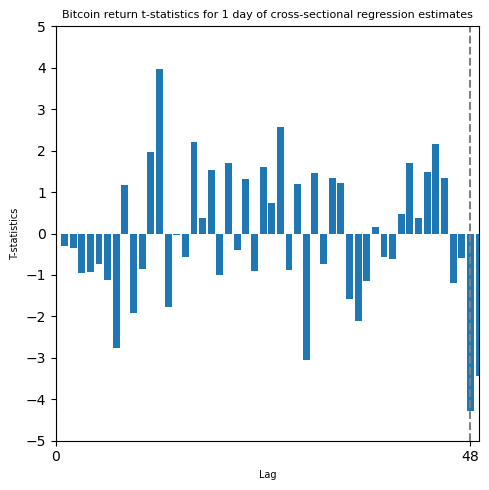

In [536]:
# Extract t-statistic values
tvalue_btc = BTC_lag1440_ret_reg.tvalues
tstats = np.array(tvalue_btc)
# Delete intercept coef
tstats = np.delete(tstats, 0)
tstats = np.insert(tstats, 0, 0)
lags = np.delete(coef_btc.index, 0)
lags = np.array([int(re.findall('\d+', lag)[0]) for lag in lags])
lags = np.insert(lags, 0, 0)
# Create a bar plot
tstats = tstats[:337]
lags = lags[:337]
fig, ax = plt.subplots(figsize=(24, 8))
ax.bar(lags, tstats)
ax.set_ylabel('T-statistics')
ax.set_xlabel('Lag')
# set the y limit
# ax.set_ylim(-5, 8)
# set the x ticks
ax.set_xticks(lags[::48])
ax.set_yticks([i for i in range(-5, 6)])
ax.set_xlim(lags.min(), lags.max())
# insert vertical lines for plot
xticks = ax.get_xticks()
for xtick in xticks:
    ax.axvline(x=xtick, color='gray', linestyle='--')
ax.set_title('Bitcoin return t-statistics of cross-sectional regression estimates')
fig.tight_layout()
plt.show()
fig.savefig('btc_tvalue_336.jpg')

#### Run regression for other cryptos

#### ETH

In [242]:
# shift k lags
df_returns['ETH_ret_lag1'] = df_returns['ETH_return'].shift()
df_eth_ret = df_returns[['ETH_return', 'ETH_ret_lag1']]
df_eth_ret.rename(columns={'ETH_return': 'ETH_ret_lag0'}, inplace=True)
for i in range(2, 1441):
    lag = "ETH_ret_lag" + str(i)
    df_eth_ret[lag] = df_returns['ETH_return'].shift(i)

In [243]:
# reverse dataset for better understandding of lags
df_eth_ret_r = df_eth_ret.iloc[::-1]
# remove missing data
df_eth_ret_r = df_eth_ret_r.dropna()

In [244]:
# Specify the dependent and independent variables
# dependent variable: lastest returns k = 0
# independent variables: lag returns k, k = 1 ... 1440
lag_cols = list(df_eth_ret_r.columns)
y = df_eth_ret_r[lag_cols.pop(0)]
X = df_eth_ret_r[lag_cols]
X = sm.add_constant(X) 
# Run the regression
ETH_lag1440_ret_reg = sm.OLS(y, X).fit()

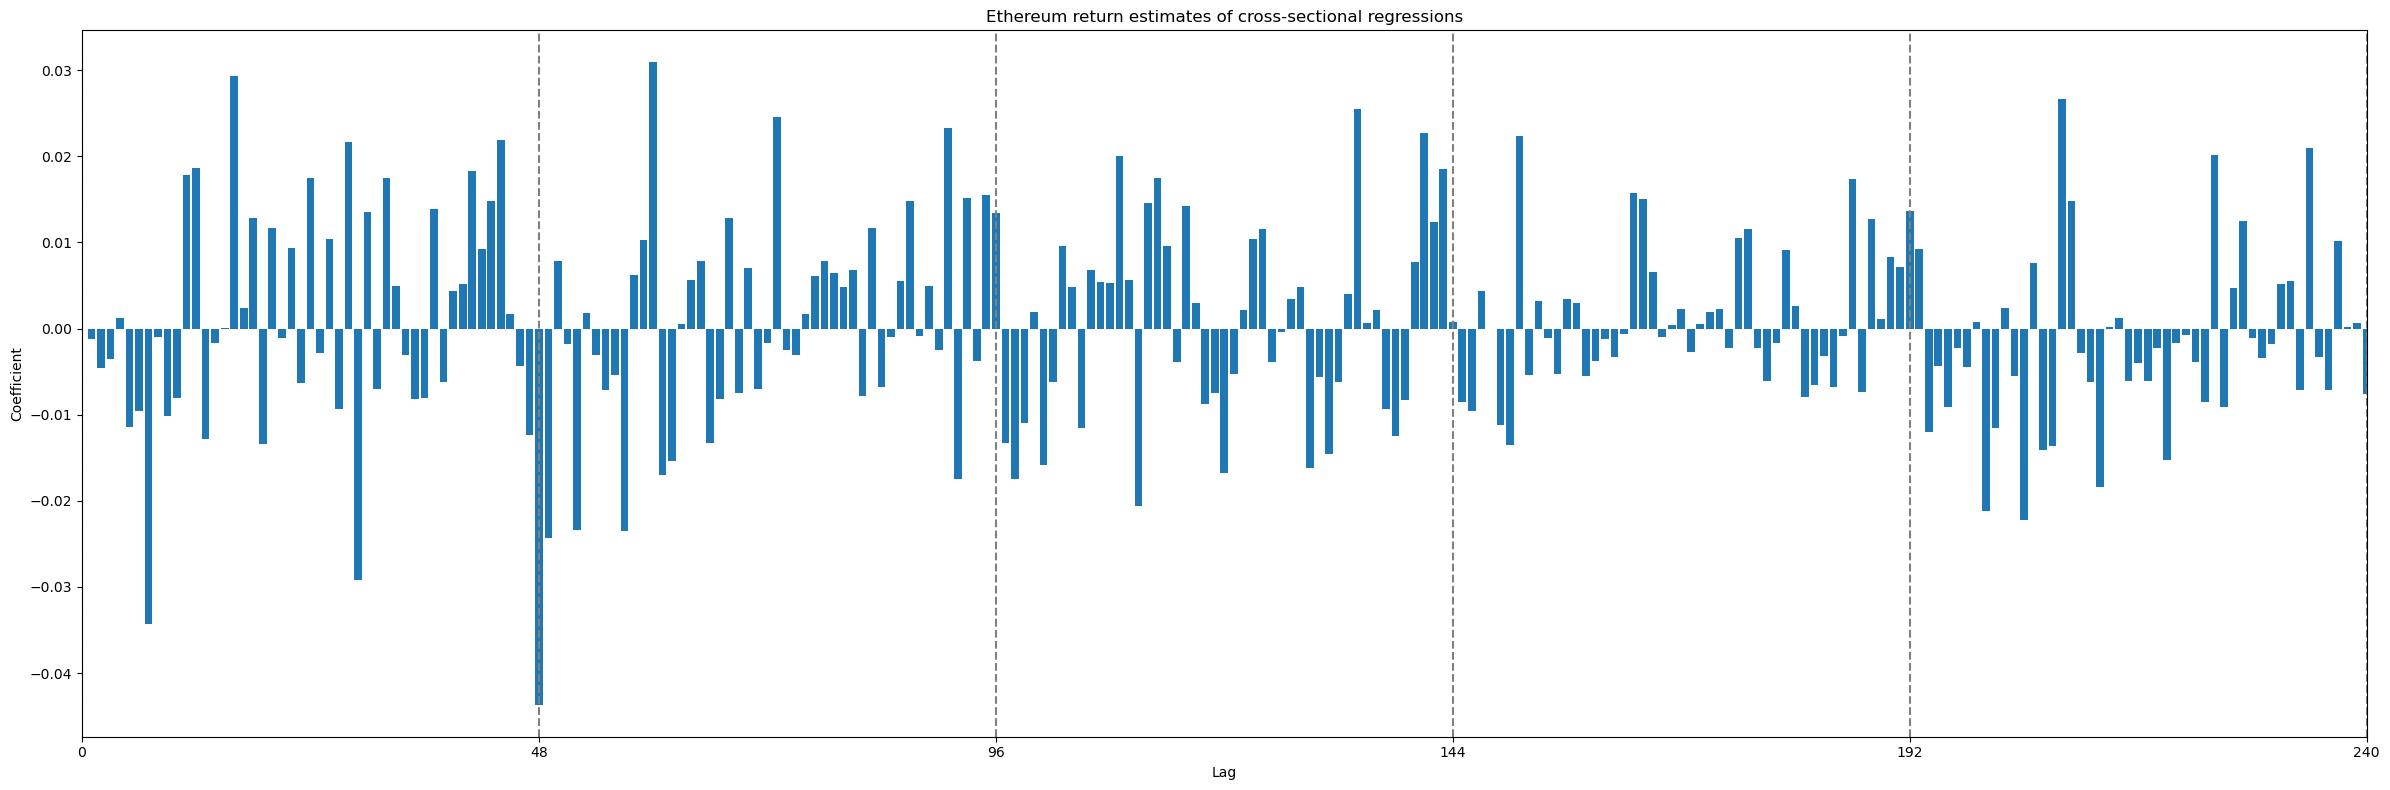

In [247]:
# Extract coefficients
coef_eth = ETH_lag1440_ret_reg.params
# Delete intercept coef
gamma = np.delete(coef_eth.values, 0)
gamma = np.insert(gamma, 0, 0)
lags = np.delete(coef_eth.index, 0)
lags = np.array([int(re.findall('\d+', lag)[0]) for lag in lags])
lags = np.insert(lags, 0, 0)
# Create a bar plot
gamma = gamma[:337]
lags = lags[:337]
fig, ax = plt.subplots(figsize=(24, 8))
ax.bar(lags, gamma)
ax.set_ylabel('Coefficient')
ax.set_xlabel('Lag')
# set the y limit
# ax.set_ylim(-0.35, 0.4)
# set the x ticks
ax.set_xticks(lags[::48])
ax.set_xlim(lags.min(), lags.max())
# insert vertical lines for plot
xticks = ax.get_xticks()
for xtick in xticks:
    ax.axvline(x=xtick, color='gray', linestyle='--')
ax.set_title('Ethereum return estimates of cross-sectional regressions')
fig.tight_layout()
plt.show()

In [249]:
# store t-stat for later use
tvalue_eth = ETH_lag1440_ret_reg.tvalues

#### DOGE

In [250]:
# shift k lags
df_returns['DOGE_ret_lag1'] = df_returns['DOGE_return'].shift()
df_doge_ret = df_returns[['DOGE_return', 'DOGE_ret_lag1']]
df_doge_ret.rename(columns={'DOGE_return': 'DOGE_ret_lag0'}, inplace=True)
for i in range(2, 1441):
    lag = "DOGE_ret_lag" + str(i)
    df_doge_ret[lag] = df_returns['DOGE_return'].shift(i)

In [251]:
# reverse dataset for better understandding of lags
df_doge_ret_r = df_doge_ret.iloc[::-1]
# remove missing data
df_doge_ret_r = df_doge_ret_r.dropna()

In [252]:
# Specify the dependent and independent variables
# dependent variable: lastest returns k = 0
# independent variables: lag returns k, k = 1 ... 1440
lag_cols = list(df_doge_ret_r.columns)
y = df_doge_ret_r[lag_cols.pop(0)]
X = df_doge_ret_r[lag_cols]
X = sm.add_constant(X) 
# Run the regression
DOGE_lag1440_ret_reg = sm.OLS(y, X).fit()

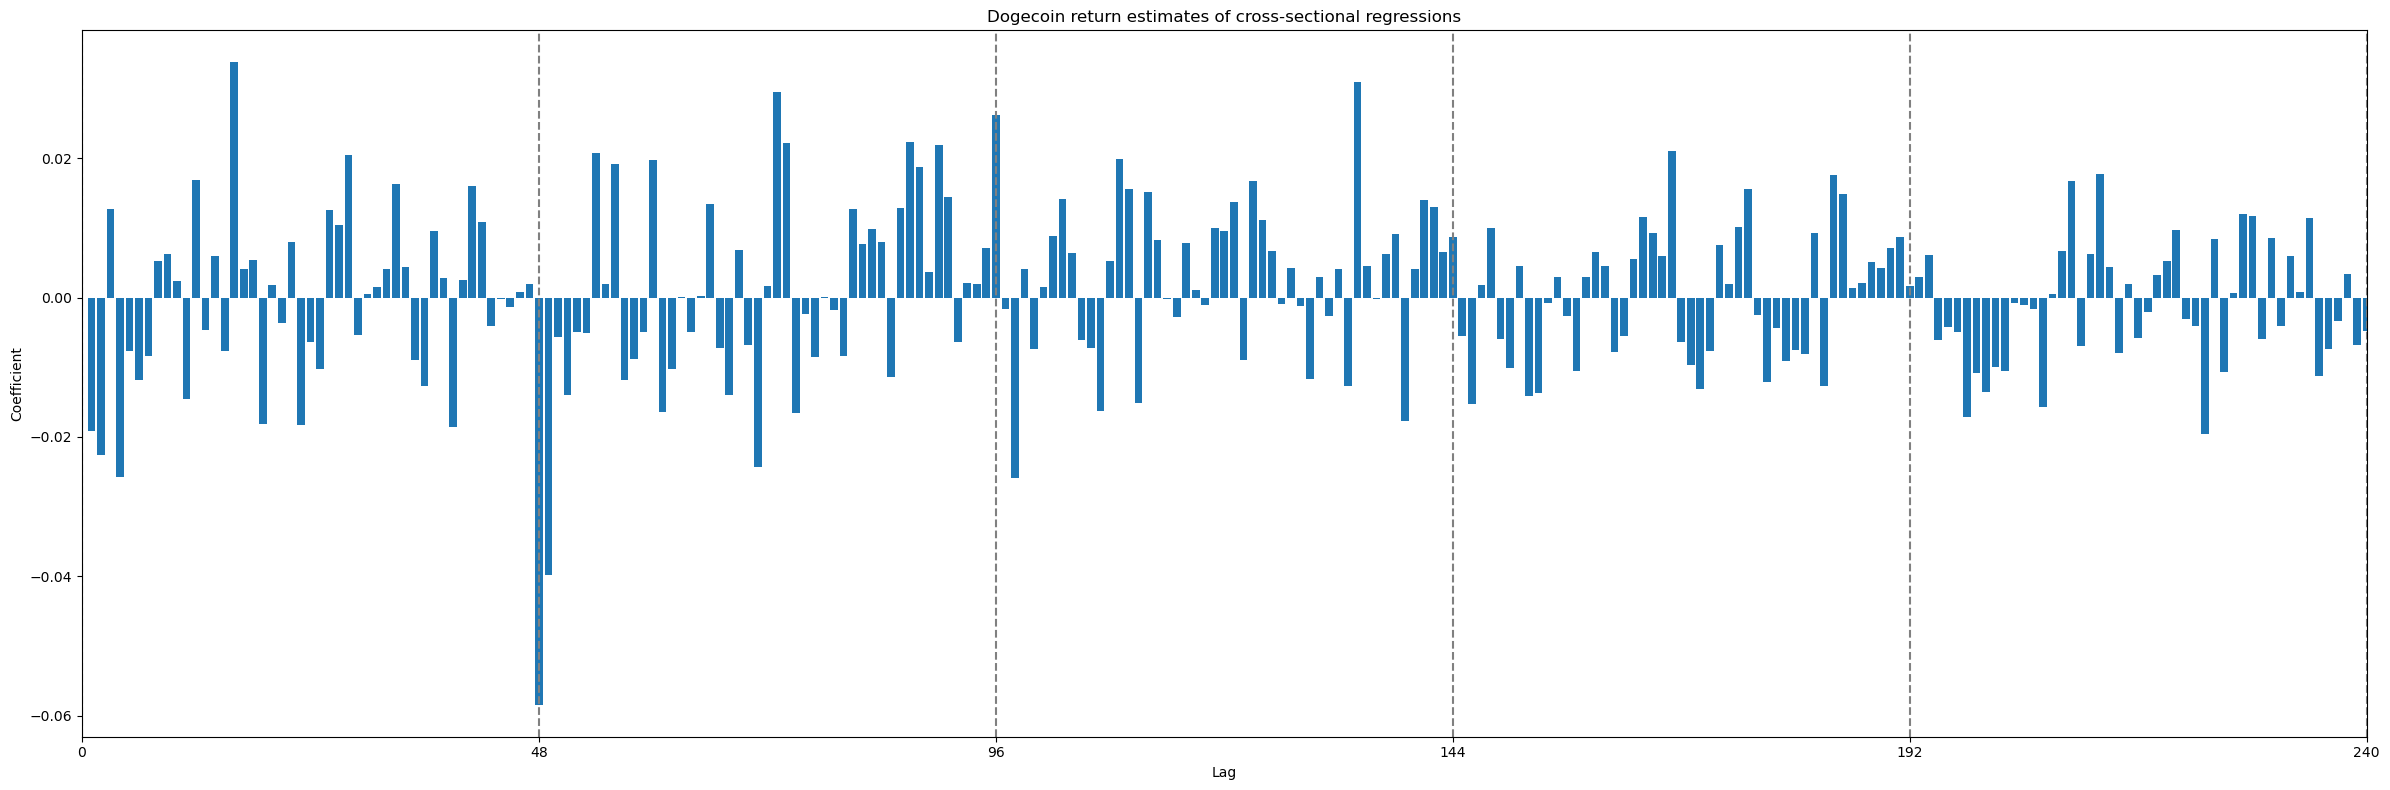

In [253]:
# Extract coefficients
coef_doge = DOGE_lag1440_ret_reg.params
# Delete intercept coef
gamma = np.delete(coef_doge.values, 0)
gamma = np.insert(gamma, 0, 0)
lags = np.delete(coef_doge.index, 0)
lags = np.array([int(re.findall('\d+', lag)[0]) for lag in lags])
lags = np.insert(lags, 0, 0)
# Create a bar plot
gamma = gamma[:337]
lags = lags[:337]
fig, ax = plt.subplots(figsize=(24, 8))
ax.bar(lags, gamma)
ax.set_ylabel('Coefficient')
ax.set_xlabel('Lag')
# set the y limit
# ax.set_ylim(-0.35, 0.4)
# set the x ticks
ax.set_xticks(lags[::48])
ax.set_xlim(lags.min(), lags.max())
# insert vertical lines for plot
xticks = ax.get_xticks()
for xtick in xticks:
    ax.axvline(x=xtick, color='gray', linestyle='--')
ax.set_title('Dogecoin return estimates of cross-sectional regressions')
fig.tight_layout()
plt.show()

In [254]:
# store t-stat for later use
tvalue_doge = DOGE_lag1440_ret_reg.tvalues

#### SOL

In [255]:
# shift k lags
df_returns['SOL_ret_lag1'] = df_returns['SOL_return'].shift()
df_sol_ret = df_returns[['SOL_return', 'SOL_ret_lag1']]
df_sol_ret.rename(columns={'SOL_return': 'SOL_ret_lag0'}, inplace=True)
for i in range(2, 1441):
    lag = "SOL_ret_lag" + str(i)
    df_sol_ret[lag] = df_returns['SOL_return'].shift(i)

In [256]:
# reverse dataset for better understandding of lags
df_sol_ret_r = df_sol_ret.iloc[::-1]
# remove missing data
df_sol_ret_r = df_sol_ret_r.dropna()

In [257]:
# Specify the dependent and independent variables
# dependent variable: lastest returns k = 0
# independent variables: lag returns k, k = 1 ... 1440
lag_cols = list(df_sol_ret_r.columns)
y = df_sol_ret_r[lag_cols.pop(0)]
X = df_sol_ret_r[lag_cols]
X = sm.add_constant(X) 
# Run the regression
SOL_lag1440_ret_reg = sm.OLS(y, X).fit()

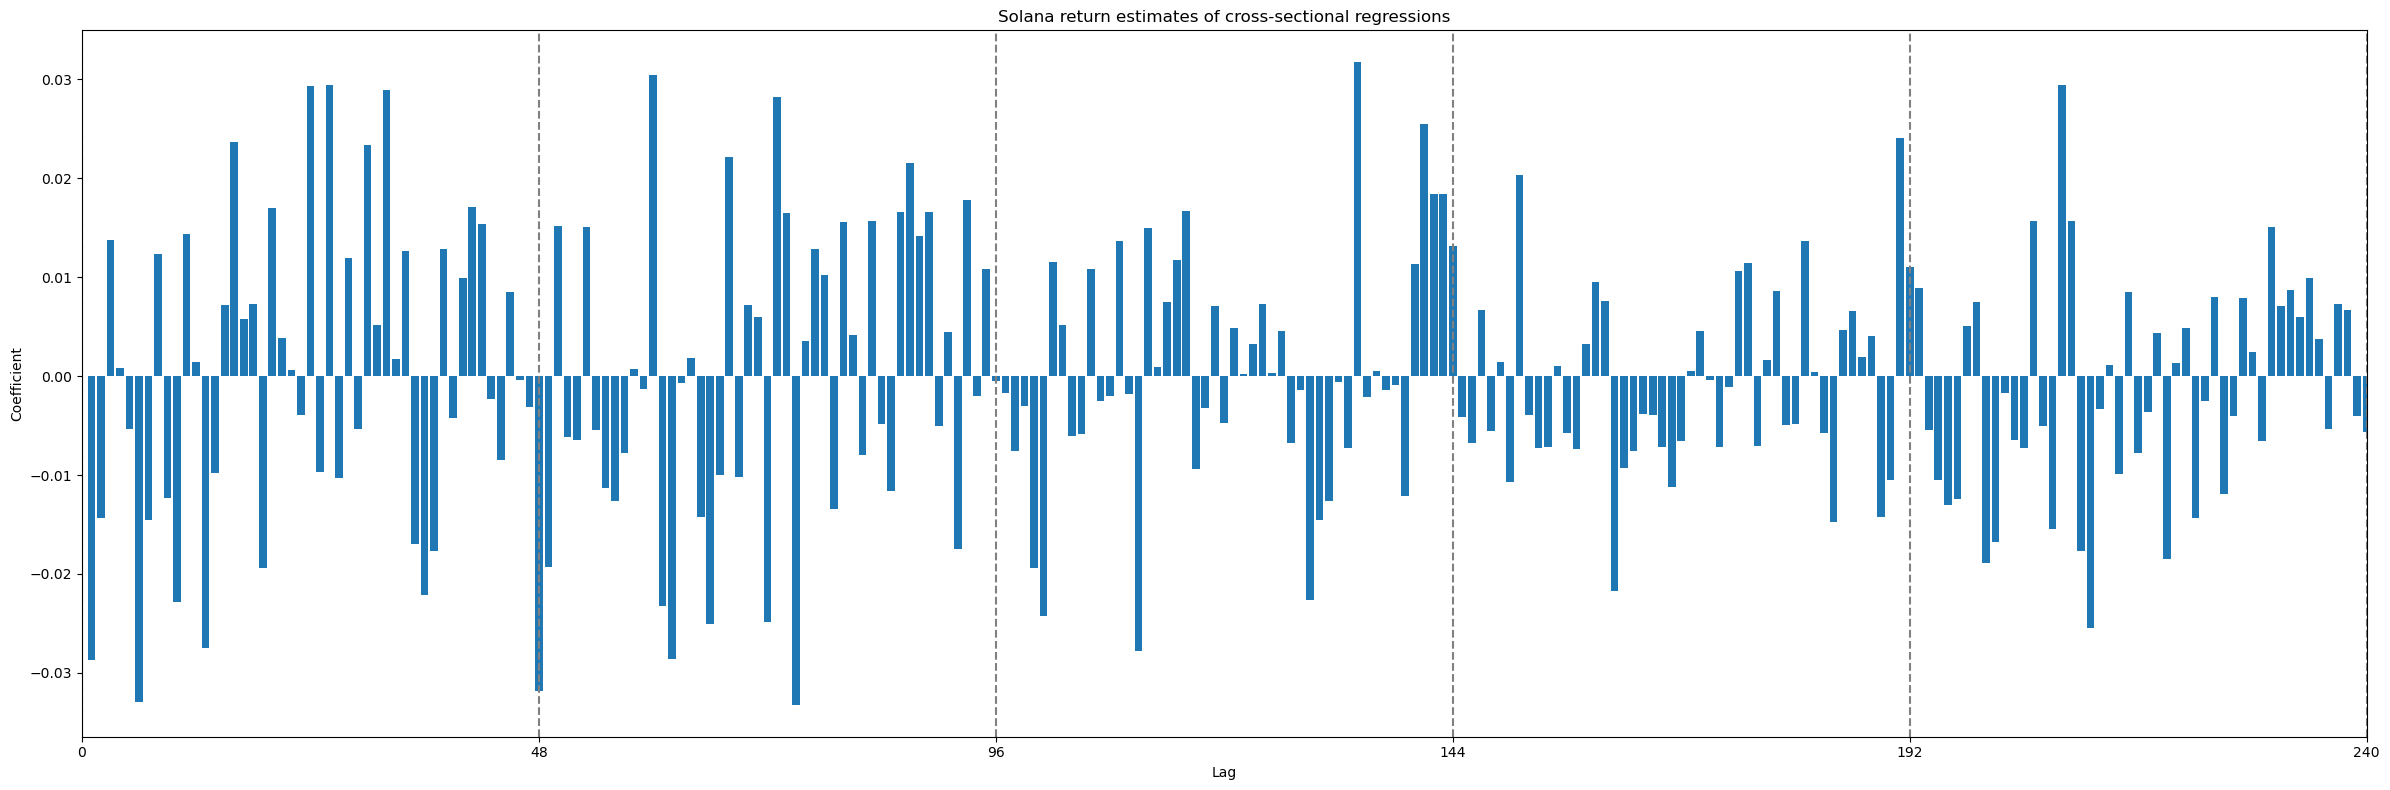

In [258]:
# Extract coefficients
coef_sol = SOL_lag1440_ret_reg.params
# Delete intercept coef
gamma = np.delete(coef_sol.values, 0)
gamma = np.insert(gamma, 0, 0)
lags = np.delete(coef_sol.index, 0)
lags = np.array([int(re.findall('\d+', lag)[0]) for lag in lags])
lags = np.insert(lags, 0, 0)
# Create a bar plot
gamma = gamma[:337]
lags = lags[:337]
fig, ax = plt.subplots(figsize=(24, 8))
ax.bar(lags, gamma)
ax.set_ylabel('Coefficient')
ax.set_xlabel('Lag')
# set the y limit
# ax.set_ylim(-0.35, 0.4)
# set the x ticks
ax.set_xticks(lags[::48])
ax.set_xlim(lags.min(), lags.max())
# insert vertical lines for plot
xticks = ax.get_xticks()
for xtick in xticks:
    ax.axvline(x=xtick, color='gray', linestyle='--')
ax.set_title('Solana return estimates of cross-sectional regressions')
fig.tight_layout()
plt.show()

In [259]:
# store t-stat for later use
tvalue_sol = SOL_lag1440_ret_reg.tvalues

#### FIL

In [260]:
# shift k lags
df_returns['FIL_ret_lag1'] = df_returns['FIL_return'].shift()
df_fil_ret = df_returns[['FIL_return', 'FIL_ret_lag1']]
df_fil_ret.rename(columns={'FIL_return': 'FIL_ret_lag0'}, inplace=True)
for i in range(2, 1441):
    lag = "FIL_ret_lag" + str(i)
    df_fil_ret[lag] = df_returns['FIL_return'].shift(i)

In [261]:
# reverse dataset for better understandding of lags
df_fil_ret_r = df_fil_ret.iloc[::-1]
# remove missing data
df_fil_ret_r = df_fil_ret_r.dropna()

In [262]:
# Specify the dependent and independent variables
# dependent variable: lastest returns k = 0
# independent variables: lag returns k, k = 1 ... 1440
lag_cols = list(df_fil_ret_r.columns)
y = df_fil_ret_r[lag_cols.pop(0)]
X = df_fil_ret_r[lag_cols]
X = sm.add_constant(X) 
# Run the regression
FIL_lag1440_ret_reg = sm.OLS(y, X).fit()

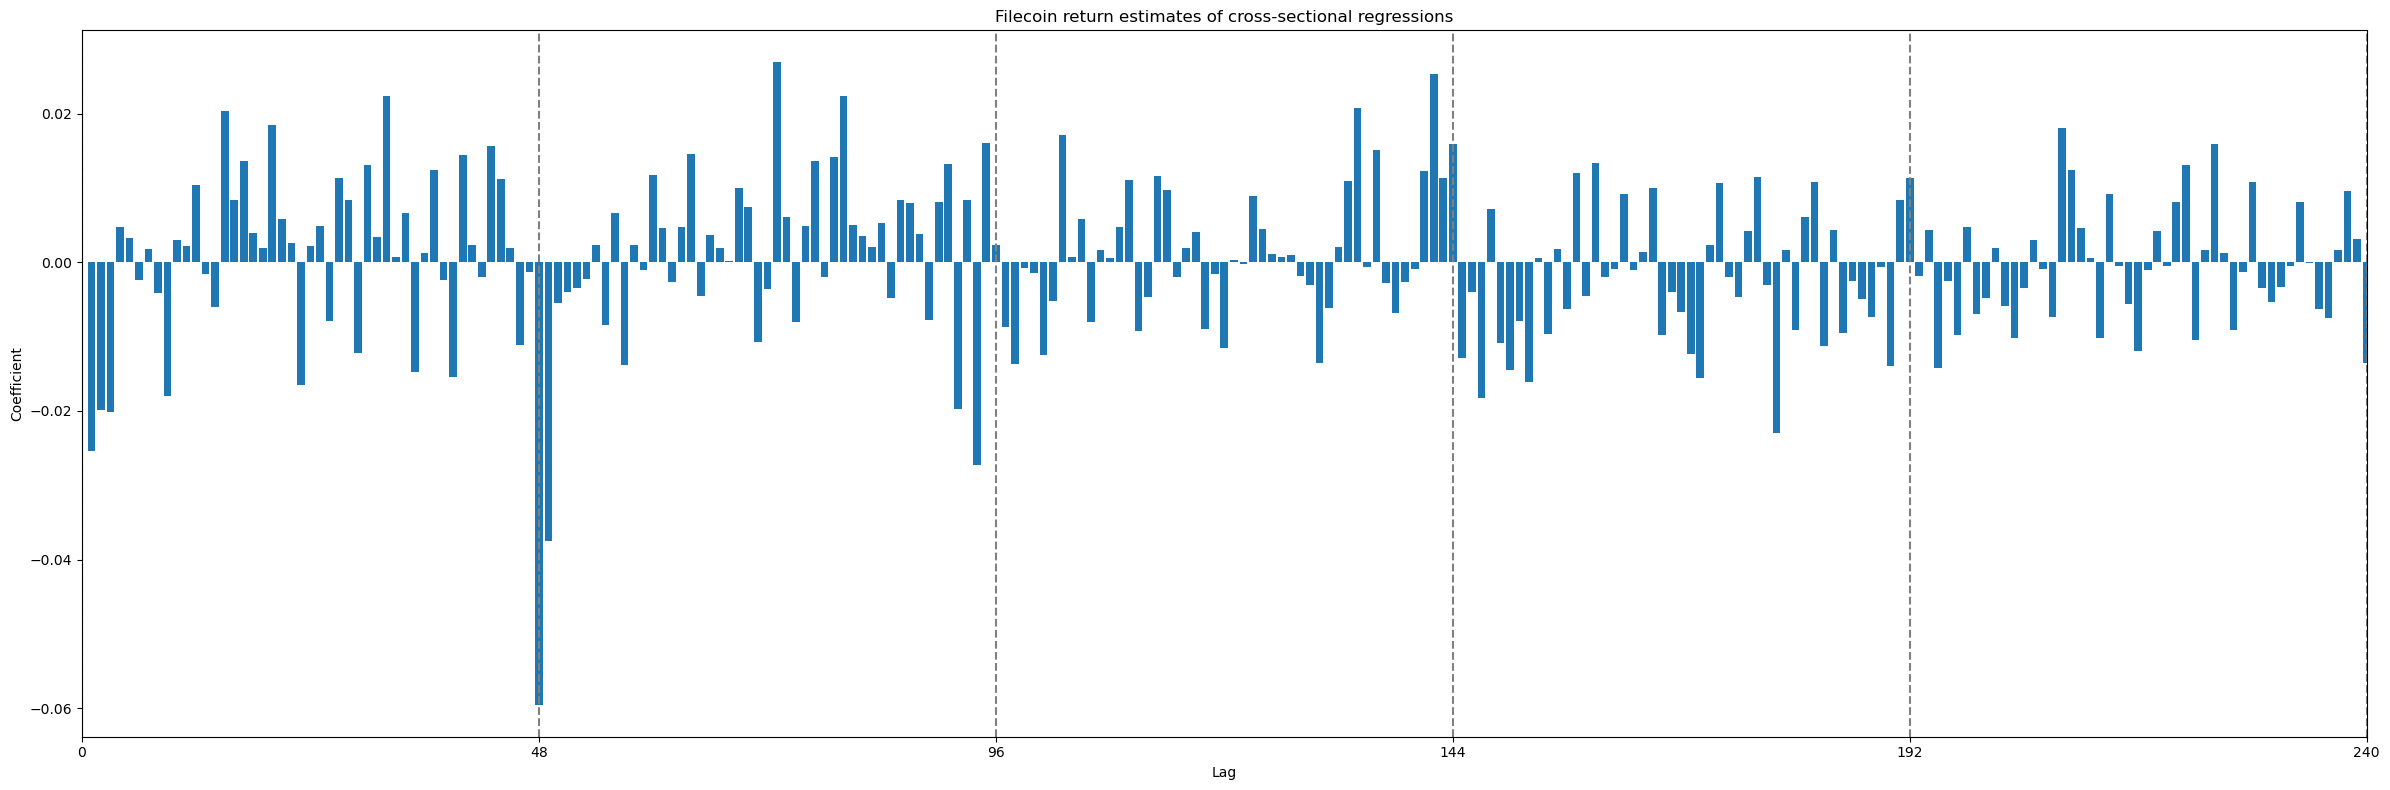

In [263]:
# Extract coefficients
coef_fil = FIL_lag1440_ret_reg.params
# Delete intercept coef
gamma = np.delete(coef_fil.values, 0)
gamma = np.insert(gamma, 0, 0)
lags = np.delete(coef_fil.index, 0)
lags = np.array([int(re.findall('\d+', lag)[0]) for lag in lags])
lags = np.insert(lags, 0, 0)
# Create a bar plot
gamma = gamma[:337]
lags = lags[:337]
fig, ax = plt.subplots(figsize=(24, 8))
ax.bar(lags, gamma)
ax.set_ylabel('Coefficient')
ax.set_xlabel('Lag')
# set the y limit
# ax.set_ylim(-0.35, 0.4)
# set the x ticks
ax.set_xticks(lags[::48])
ax.set_xlim(lags.min(), lags.max())
# insert vertical lines for plot
xticks = ax.get_xticks()
for xtick in xticks:
    ax.axvline(x=xtick, color='gray', linestyle='--')
ax.set_title('Filecoin return estimates of cross-sectional regressions')
fig.tight_layout()
plt.show()

In [264]:
# store t-stat for later use
tvalue_fil = FIL_lag1440_ret_reg.tvalues

#### LTC

In [265]:
# shift k lags
df_returns['LTC_ret_lag1'] = df_returns['LTC_return'].shift()
df_ltc_ret = df_returns[['LTC_return', 'LTC_ret_lag1']]
df_ltc_ret.rename(columns={'LTC_return': 'LTC_ret_lag0'}, inplace=True)
for i in range(2, 1441):
    lag = "LTC_ret_lag" + str(i)
    df_ltc_ret[lag] = df_returns['LTC_return'].shift(i)

In [266]:
# reverse dataset for better understandding of lags
df_ltc_ret_r = df_ltc_ret.iloc[::-1]
# remove missing data
df_ltc_ret_r = df_ltc_ret_r.dropna()

In [267]:
# Specify the dependent and independent variables
# dependent variable: lastest returns k = 0
# independent variables: lag returns k, k = 1 ... 1440
lag_cols = list(df_ltc_ret_r.columns)
y = df_ltc_ret_r[lag_cols.pop(0)]
X = df_ltc_ret_r[lag_cols]
X = sm.add_constant(X) 
# Run the regression
LTC_lag1440_ret_reg = sm.OLS(y, X).fit()

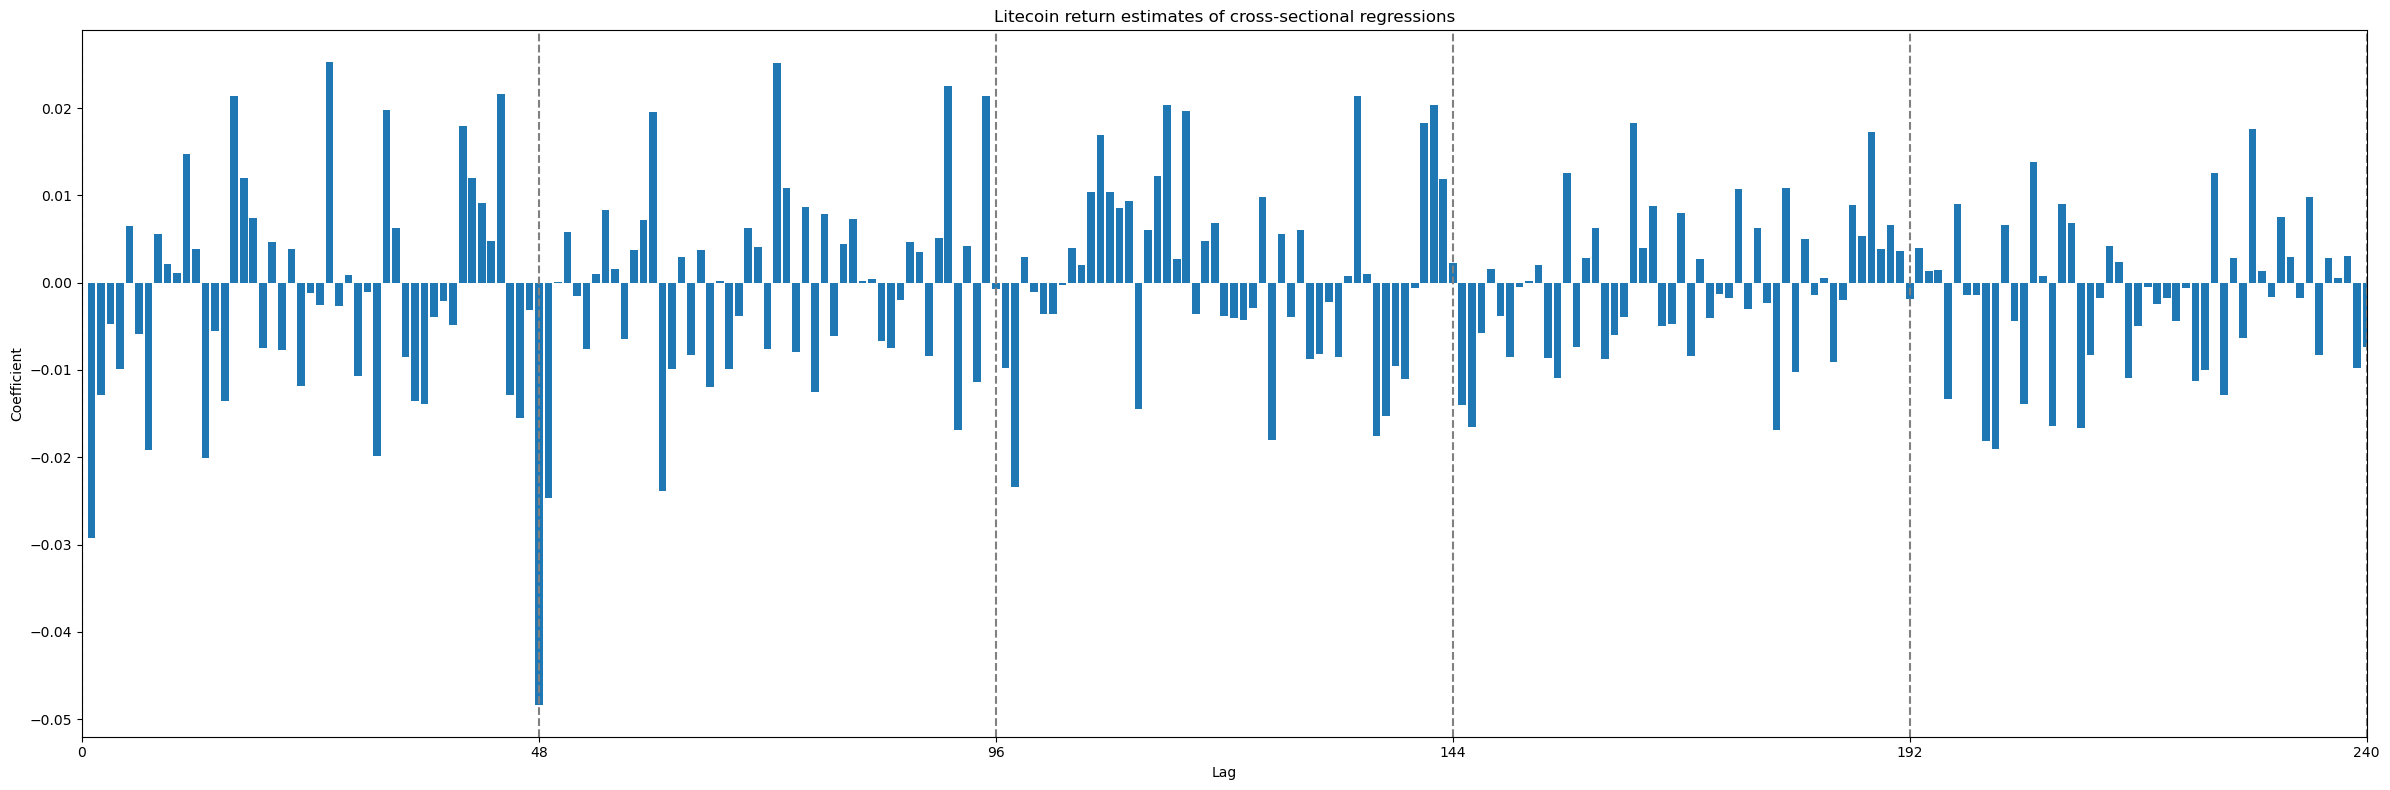

In [269]:
# Extract coefficients
coef_ltc = LTC_lag1440_ret_reg.params
# Delete intercept coef
gamma = np.delete(coef_ltc.values, 0)
gamma = np.insert(gamma, 0, 0)
lags = np.delete(coef_ltc.index, 0)
lags = np.array([int(re.findall('\d+', lag)[0]) for lag in lags])
lags = np.insert(lags, 0, 0)
# Create a bar plot
gamma = gamma[:337]
lags = lags[:337]
fig, ax = plt.subplots(figsize=(24, 8))
ax.bar(lags, gamma)
ax.set_ylabel('Coefficient')
ax.set_xlabel('Lag')
# set the y limit
# ax.set_ylim(-0.5, 0.5)
# set the x ticks
ax.set_xticks(lags[::48])
ax.set_xlim(lags.min(), lags.max())
# insert vertical lines for plot
xticks = ax.get_xticks()
for xtick in xticks:
    ax.axvline(x=xtick, color='gray', linestyle='--')
ax.set_title('Litecoin return estimates of cross-sectional regressions')
fig.tight_layout()
plt.show()

In [270]:
# store t-stat for later use
tvalue_ltc = LTC_lag1440_ret_reg.tvalues

#### SHIB

In [271]:
# shift k lags
df_returns['SHIB_ret_lag1'] = df_returns['SHIB_return'].shift()
df_shib_ret = df_returns[['SHIB_return', 'SHIB_ret_lag1']]
df_shib_ret.rename(columns={'SHIB_return': 'SHIB_ret_lag0'}, inplace=True)
for i in range(2, 1441):
    lag = "SHIB_ret_lag" + str(i)
    df_shib_ret[lag] = df_returns['SHIB_return'].shift(i)

In [272]:
# # This is the approach to run regression for all data
# cols = list(df_shib_ret.columns)
# formula = cols[0] + '~' + cols[1]
# for i in range(2, len(cols)):
#     formula += '+' + cols[i]
#     if i == 480:
#         break
# reg = smf.ols(formula=formula, data=df_shib_ret).fit()

In [273]:
# reverse dataset for better understandding of lags
df_shib_ret_r = df_shib_ret.iloc[::-1]
# remove missing data
df_shib_ret_r = df_shib_ret_r.dropna()

In [274]:
# Specify the dependent and independent variables
# dependent variable: lastest returns k = 0
# independent variables: lag returns k, k = 1 ... 1440
lag_cols = list(df_shib_ret_r.columns)
y = df_shib_ret_r[lag_cols.pop(0)]
X = df_shib_ret_r[lag_cols]
X = sm.add_constant(X) 
# Run the regression
SHIB_lag1440_ret_reg = sm.OLS(y, X).fit()

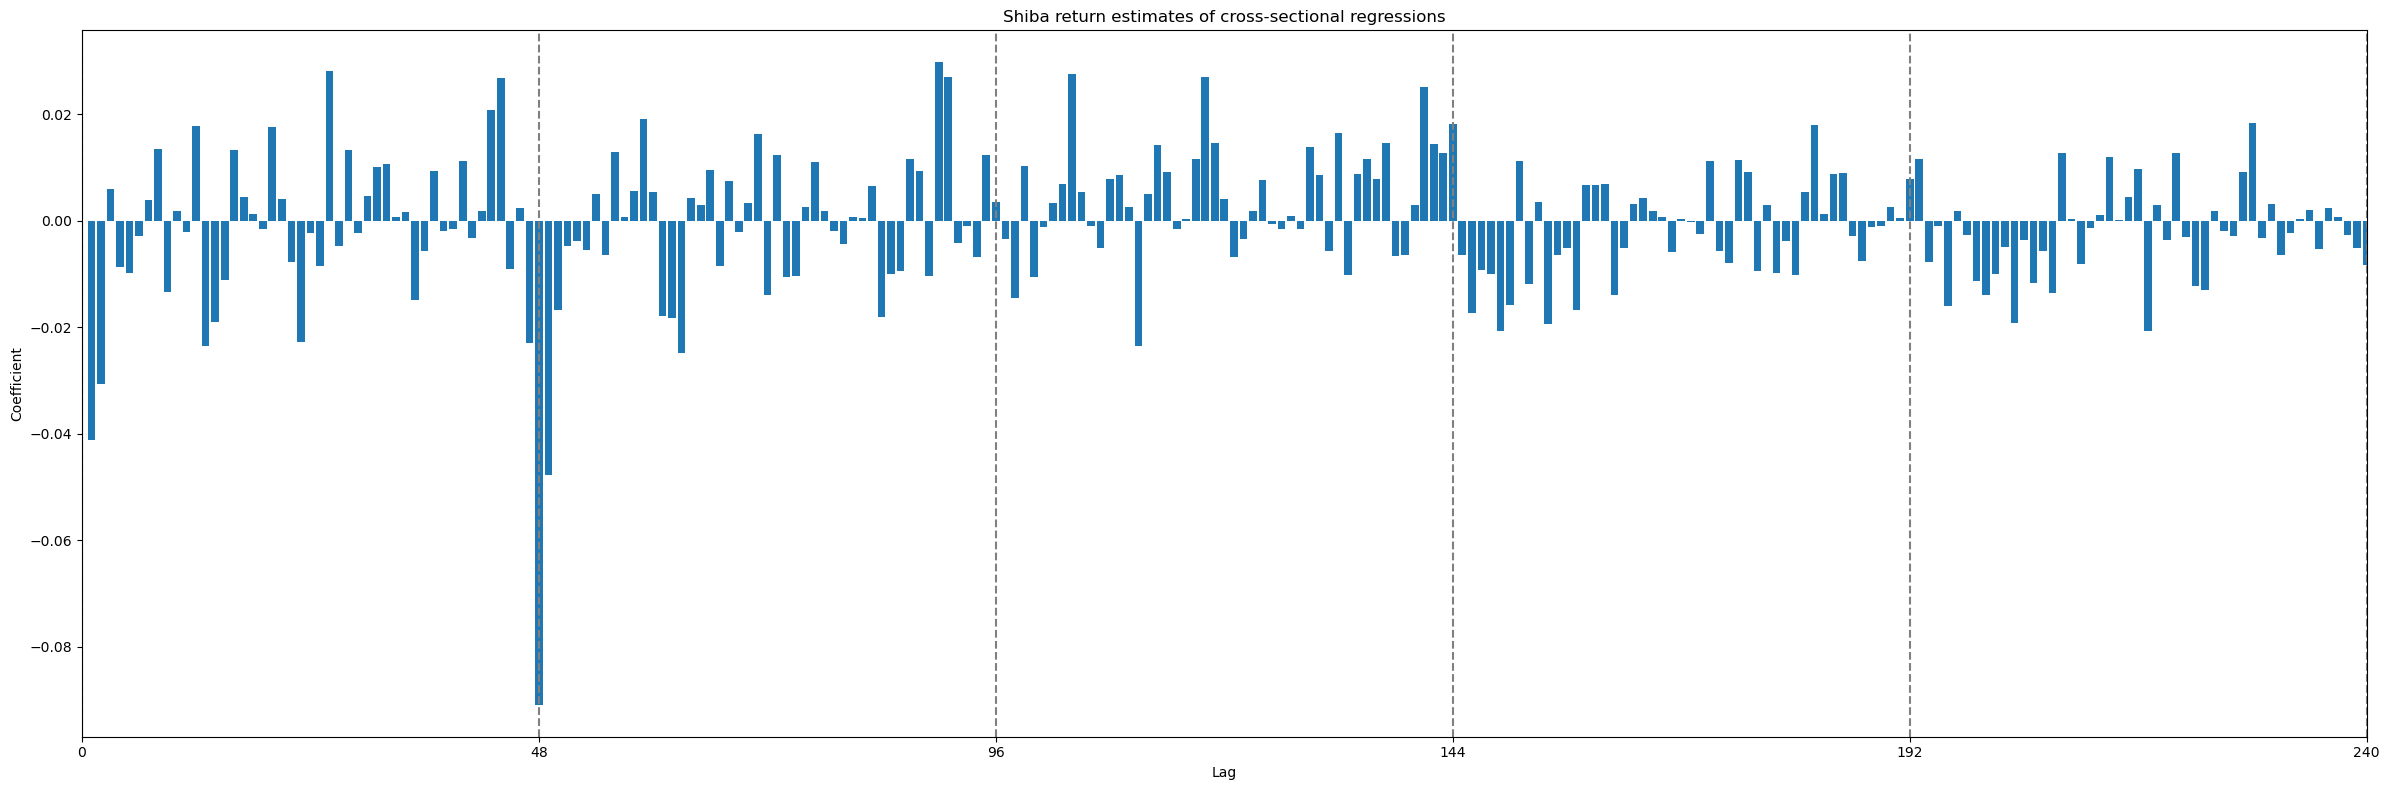

In [275]:
# Extract coefficients
coef_shib = SHIB_lag1440_ret_reg.params
# Delete intercept coef
gamma = np.delete(coef_shib.values, 0)
gamma = np.insert(gamma, 0, 0)
lags = np.delete(coef_shib.index, 0)
lags = np.array([int(re.findall('\d+', lag)[0]) for lag in lags])
lags = np.insert(lags, 0, 0)
# Create a bar plot
gamma = gamma[:337]
lags = lags[:337]
fig, ax = plt.subplots(figsize=(24, 8))
ax.bar(lags, gamma)
ax.set_ylabel('Coefficient')
ax.set_xlabel('Lag')
# set the y limit
# ax.set_ylim(-0.5, 0.5)
# set the x ticks
ax.set_xticks(lags[::48])
ax.set_xlim(lags.min(), lags.max())
# insert vertical lines for plot
xticks = ax.get_xticks()
for xtick in xticks:
    ax.axvline(x=xtick, color='gray', linestyle='--')
ax.set_title('Shiba return estimates of cross-sectional regressions')
fig.tight_layout()
plt.show()

In [276]:
# store t-stat for later use
tvalue_shib = SHIB_lag1440_ret_reg.tvalues

#### BNB

In [277]:
# shift k lags
df_returns['BNB_ret_lag1'] = df_returns['BNB_return'].shift()
df_bnb_ret = df_returns[['BNB_return', 'BNB_ret_lag1']]
df_bnb_ret.rename(columns={'BNB_return': 'BNB_ret_lag0'}, inplace=True)
for i in range(2, 1441):
    lag = "BNB_ret_lag" + str(i)
    df_bnb_ret[lag] = df_returns['BNB_return'].shift(i)

In [278]:
# reverse dataset for better understandding of lags
df_bnb_ret_r = df_bnb_ret.iloc[::-1]
# remove missing data
df_bnb_ret_r = df_bnb_ret_r.dropna()

In [279]:
# Specify the dependent and independent variables
# dependent variable: lastest returns k = 0
# independent variables: lag returns k, k = 1 ... 1440
lag_cols = list(df_bnb_ret_r.columns)
y = df_bnb_ret_r[lag_cols.pop(0)]
X = df_bnb_ret_r[lag_cols]
X = sm.add_constant(X) 
# Run the regression
BNB_lag1440_ret_reg = sm.OLS(y, X).fit()

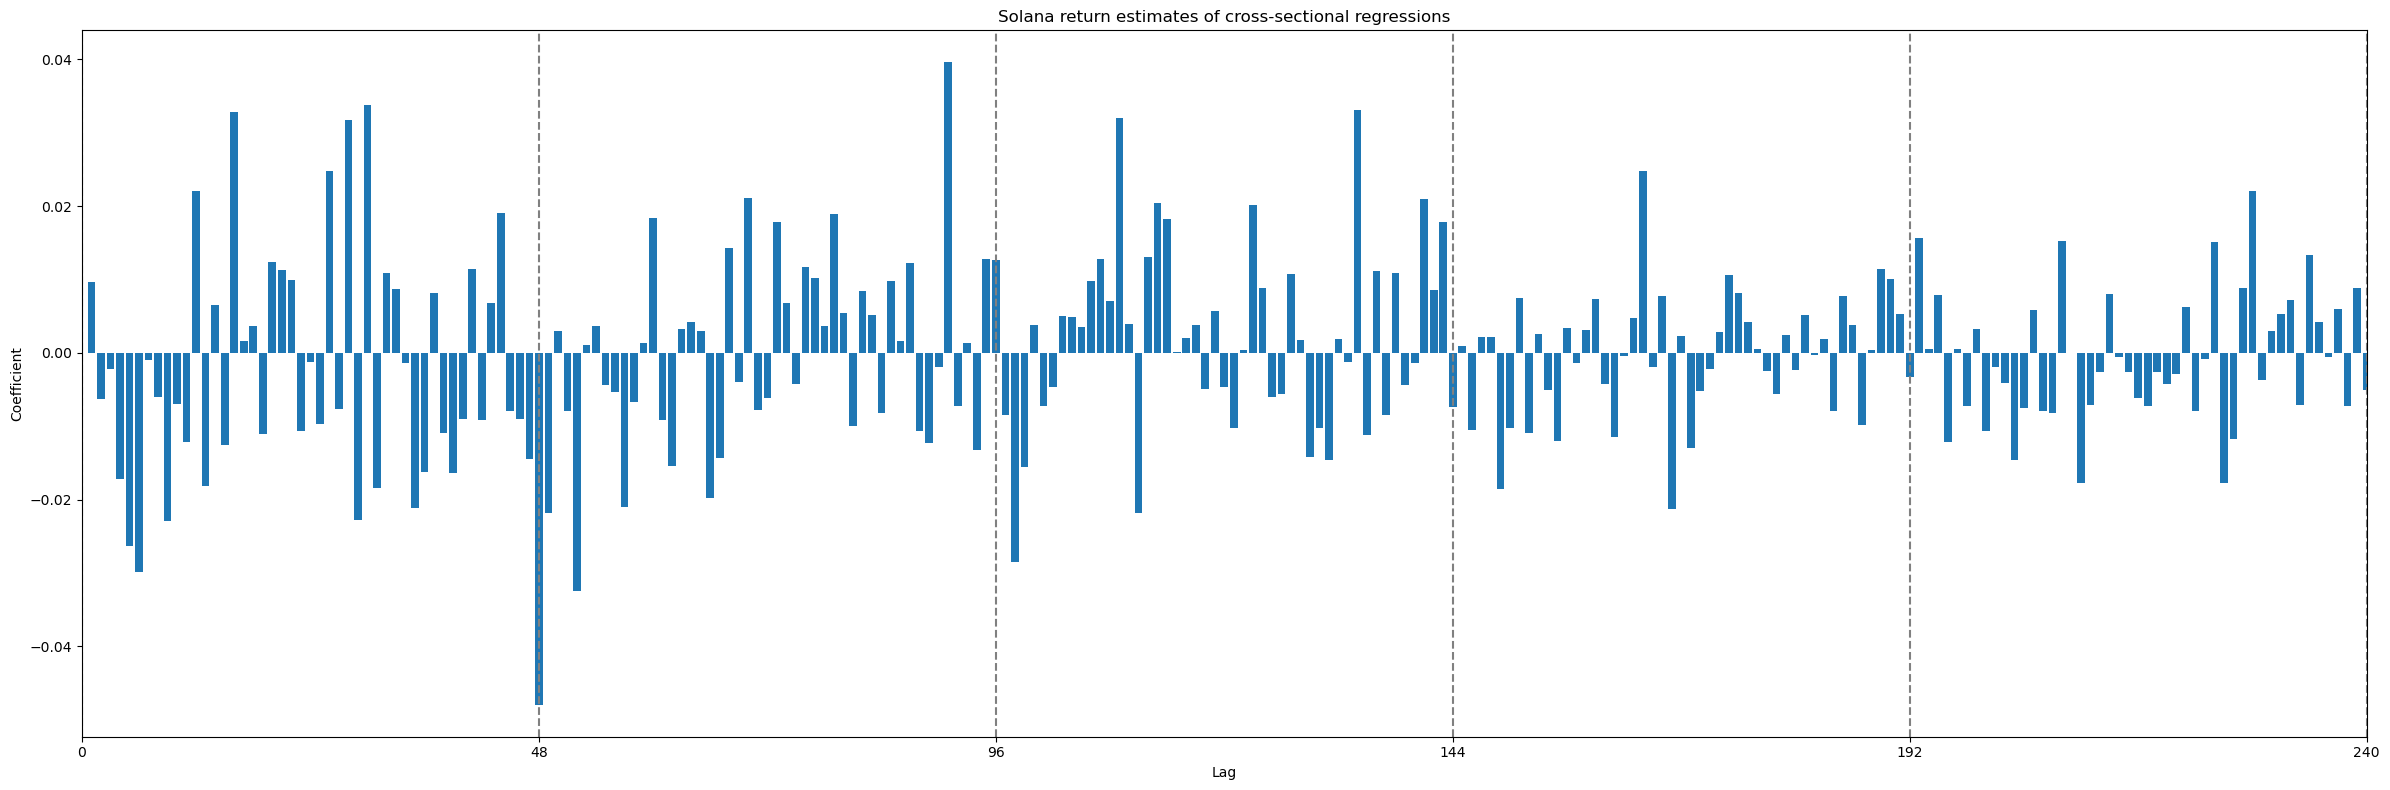

In [280]:
# Extract coefficients
coef_bnb = BNB_lag1440_ret_reg.params
# Delete intercept coef
gamma = np.delete(coef_bnb.values, 0)
gamma = np.insert(gamma, 0, 0)
lags = np.delete(coef_bnb.index, 0)
lags = np.array([int(re.findall('\d+', lag)[0]) for lag in lags])
lags = np.insert(lags, 0, 0)
# Create a bar plot
gamma = gamma[:337]
lags = lags[:337]
fig, ax = plt.subplots(figsize=(24, 8))
ax.bar(lags, gamma)
ax.set_ylabel('Coefficient')
ax.set_xlabel('Lag')
# set the y limit
# ax.set_ylim(-0.35, 0.4)
# set the x ticks
ax.set_xticks(lags[::48])
ax.set_xlim(lags.min(), lags.max())
# insert vertical lines for plot
xticks = ax.get_xticks()
for xtick in xticks:
    ax.axvline(x=xtick, color='gray', linestyle='--')
ax.set_title('Solana return estimates of cross-sectional regressions')
fig.tight_layout()
plt.show()

In [281]:
# store t-stat for later use
tvalue_bnb = BNB_lag1440_ret_reg.tvalues

#### XRP

In [282]:
# shift k lags
df_returns['XRP_ret_lag1'] = df_returns['XRP_return'].shift()
df_xrp_ret = df_returns[['XRP_return', 'XRP_ret_lag1']]
df_xrp_ret.rename(columns={'XRP_return': 'XRP_ret_lag0'}, inplace=True)
for i in range(2, 1441):
    lag = "XRP_ret_lag" + str(i)
    df_xrp_ret[lag] = df_returns['XRP_return'].shift(i)

In [283]:
# reverse dataset for better understandding of lags
df_xrp_ret_r = df_xrp_ret.iloc[::-1]
# remove missing data
df_xrp_ret_r = df_xrp_ret_r.dropna()

In [284]:
# Specify the dependent and independent variables
# dependent variable: lastest returns k = 0
# independent variables: lag returns k, k = 1 ... 1440
lag_cols = list(df_xrp_ret_r.columns)
y = df_xrp_ret_r[lag_cols.pop(0)]
X = df_xrp_ret_r[lag_cols]
X = sm.add_constant(X) 
# Run the regression
XRP_lag1440_ret_reg = sm.OLS(y, X).fit()

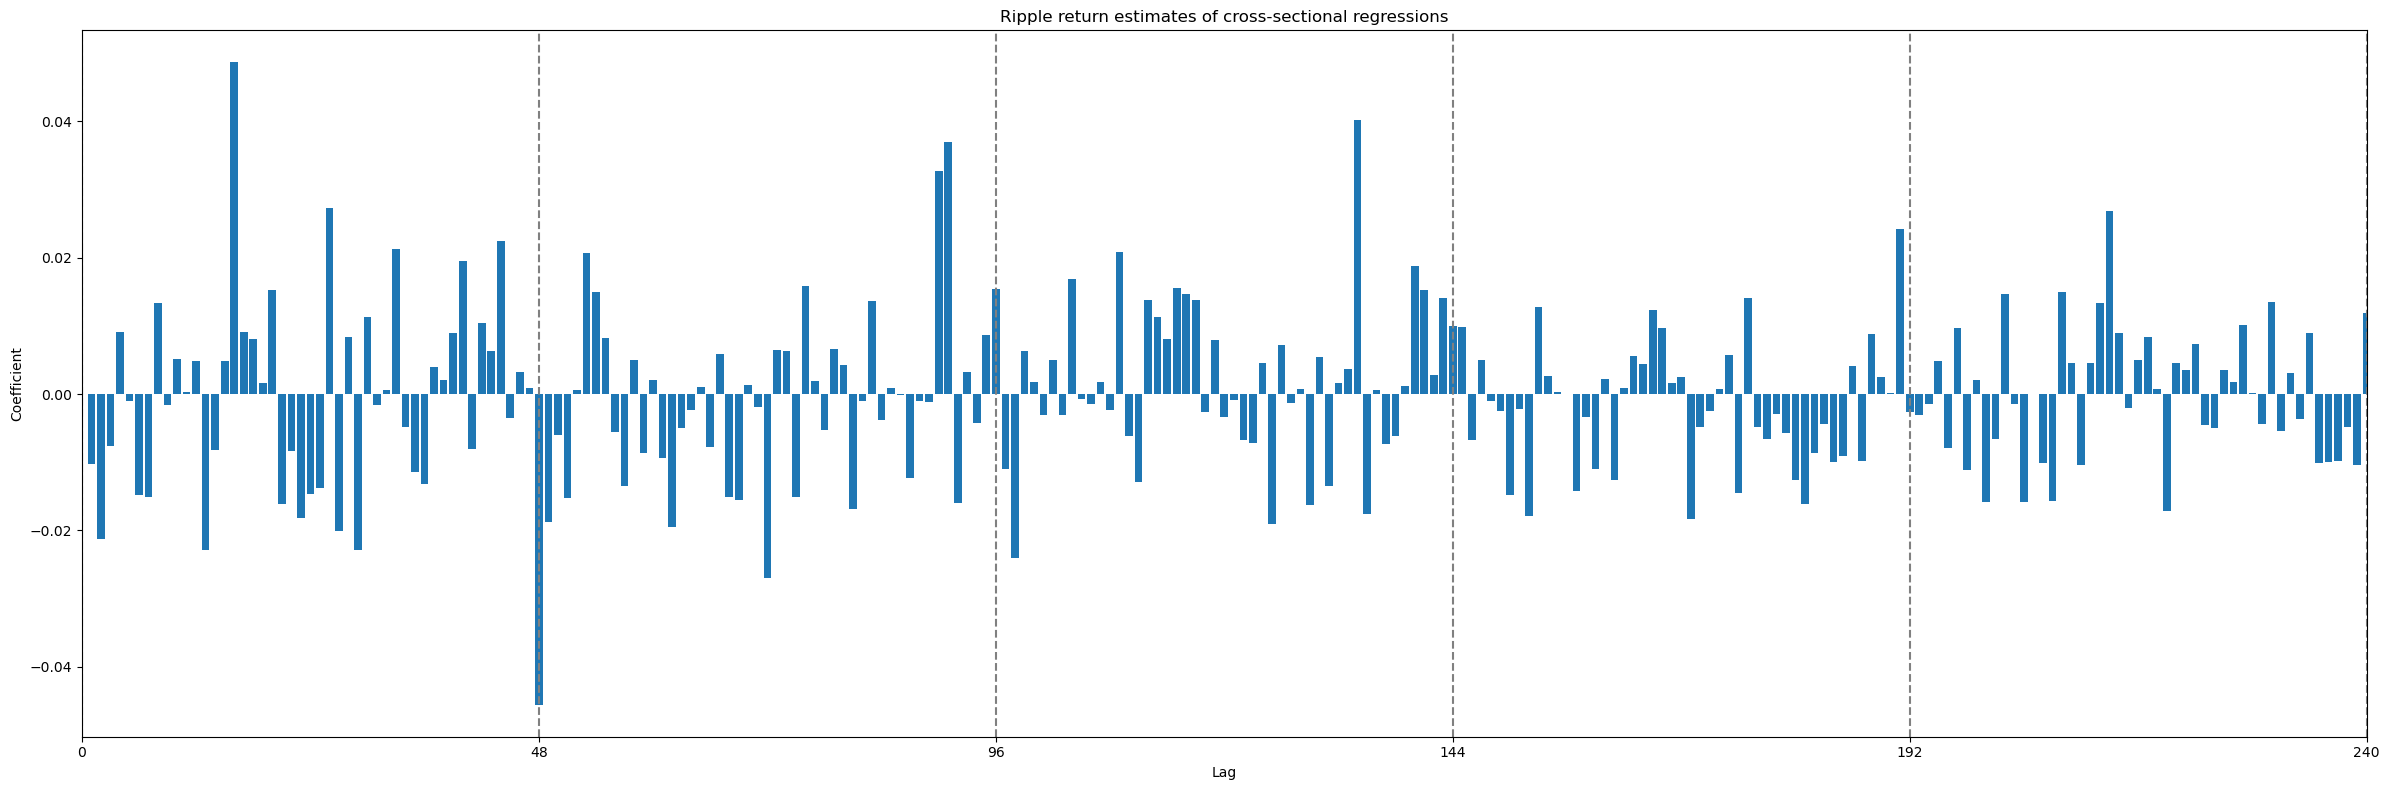

In [286]:
# Extract coefficients
coef_xrp = XRP_lag1440_ret_reg.params
# Delete intercept coef
gamma = np.delete(coef_xrp.values, 0)
gamma = np.insert(gamma, 0, 0)
lags = np.delete(coef_xrp.index, 0)
lags = np.array([int(re.findall('\d+', lag)[0]) for lag in lags])
lags = np.insert(lags, 0, 0)
# Create a bar plot
gamma = gamma[:337]
lags = lags[:337]
fig, ax = plt.subplots(figsize=(24, 8))
ax.bar(lags, gamma)
ax.set_ylabel('Coefficient')
ax.set_xlabel('Lag')
# set the y limit
# ax.set_ylim(-0.35, 0.4)
# set the x ticks
ax.set_xticks(lags[::48])
ax.set_xlim(lags.min(), lags.max())
# insert vertical lines for plot
xticks = ax.get_xticks()
for xtick in xticks:
    ax.axvline(x=xtick, color='gray', linestyle='--')
ax.set_title('Ripple return estimates of cross-sectional regressions')
fig.tight_layout()
plt.show()

In [287]:
# store t-stat for later use
tvalue_xrp = XRP_lag1440_ret_reg.tvalues

#### AAVE

In [288]:
# shift k lags
df_returns['AAVE_ret_lag1'] = df_returns['AAVE_return'].shift()
df_aave_ret = df_returns[['AAVE_return', 'AAVE_ret_lag1']]
df_aave_ret.rename(columns={'AAVE_return': 'AAVE_ret_lag0'}, inplace=True)
for i in range(2, 1441):
    lag = "AAVE_ret_lag" + str(i)
    df_aave_ret[lag] = df_returns['AAVE_return'].shift(i)

In [289]:
# reverse dataset for better understandding of lags
df_aave_ret_r = df_aave_ret.iloc[::-1]
# remove missing data
df_aave_ret_r = df_aave_ret_r.dropna()

In [290]:
# Specify the dependent and independent variables
# dependent variable: lastest returns k = 0
# independent variables: lag returns k, k = 1 ... 1440
lag_cols = list(df_aave_ret_r.columns)
y = df_aave_ret_r[lag_cols.pop(0)]
X = df_aave_ret_r[lag_cols]
X = sm.add_constant(X) 
# Run the regression
AAVE_lag1440_ret_reg = sm.OLS(y, X).fit()

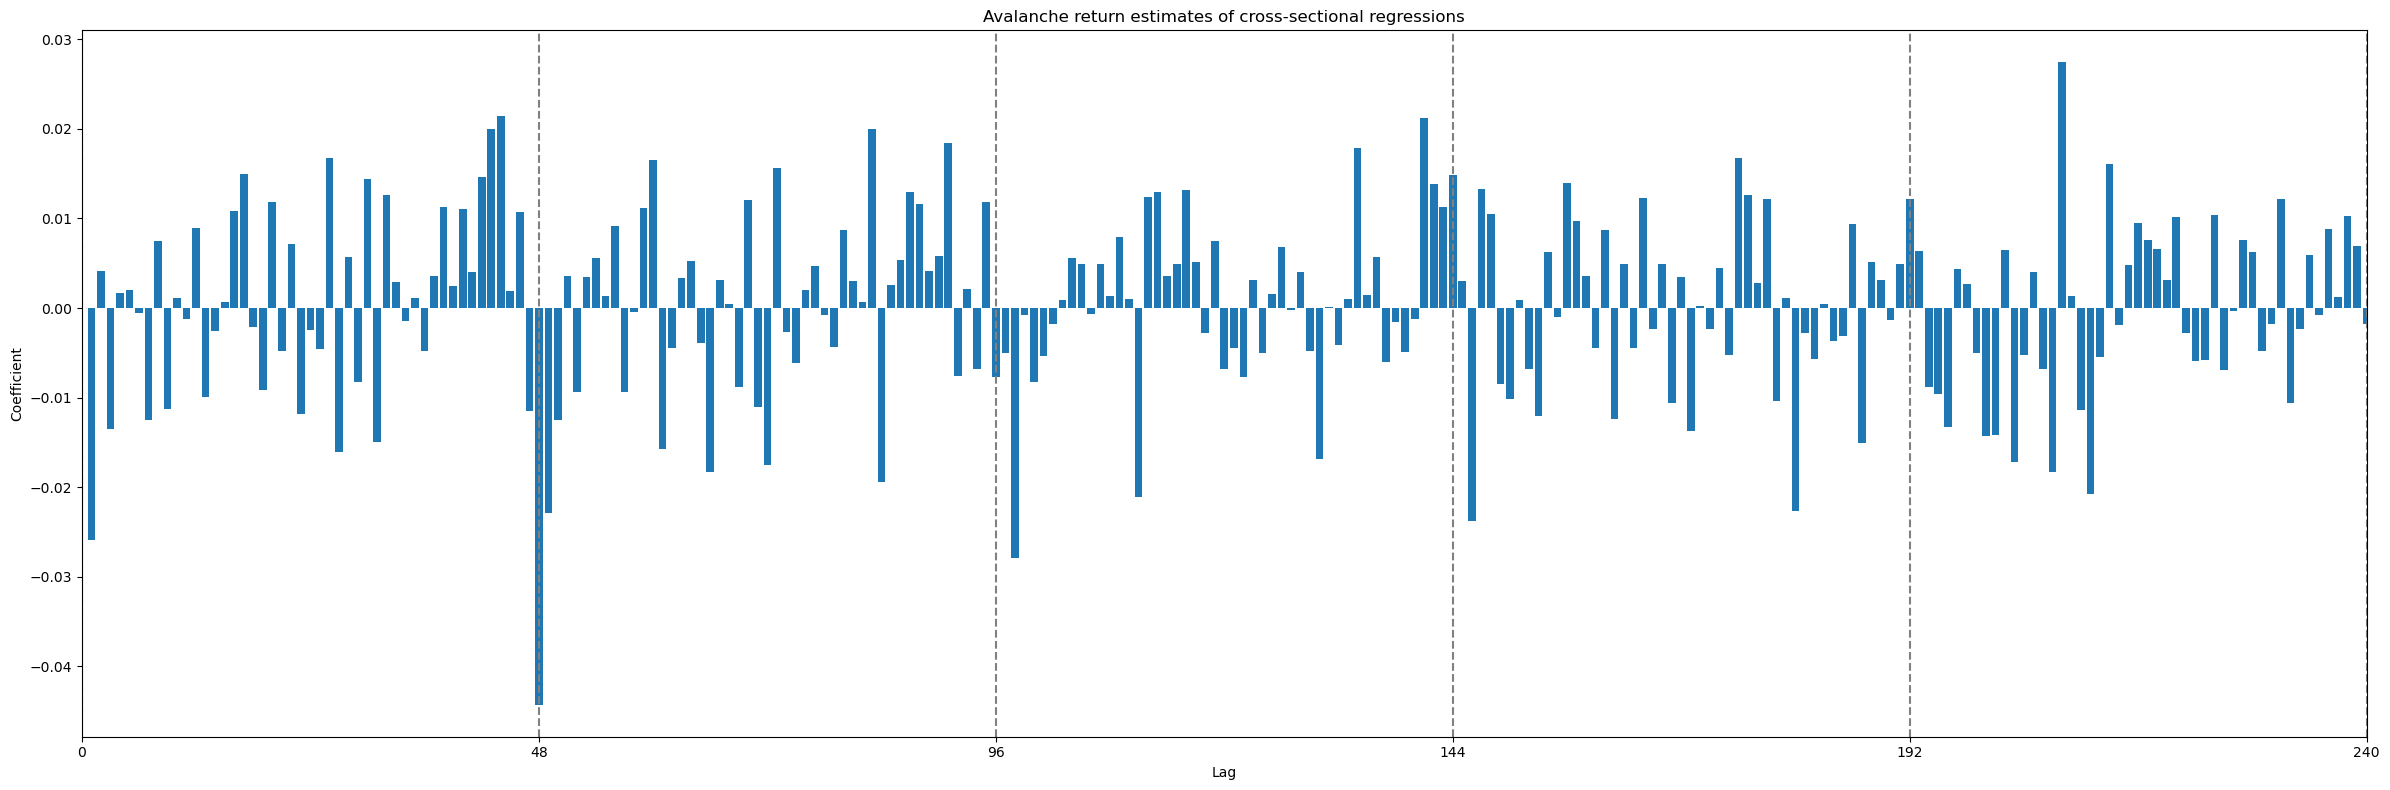

In [293]:
# Extract coefficients
coef_aave = AAVE_lag1440_ret_reg.params
# Delete intercept coef
gamma = np.delete(coef_aave.values, 0)
gamma = np.insert(gamma, 0, 0)
lags = np.delete(coef_aave.index, 0)
lags = np.array([int(re.findall('\d+', lag)[0]) for lag in lags])
lags = np.insert(lags, 0, 0)
# Create a bar plot
gamma = gamma[:337]
lags = lags[:337]
fig, ax = plt.subplots(figsize=(24, 8))
ax.bar(lags, gamma)
ax.set_ylabel('Coefficient')
ax.set_xlabel('Lag')
# set the y limit
# ax.set_ylim(-0.35, 0.3)
# set the x ticks
ax.set_xticks(lags[::48])
ax.set_xlim(lags.min(), lags.max())
# insert vertical lines for plot
xticks = ax.get_xticks()
for xtick in xticks:
    ax.axvline(x=xtick, color='gray', linestyle='--')
ax.set_title('Avalanche return estimates of cross-sectional regressions')
fig.tight_layout()
plt.show()

In [292]:
# store t-stat for later use
tvalue_aave = AAVE_lag1440_ret_reg.tvalues

#### Plot portfolio estimates to make the 10 cryptos as a portfolio and find the decile estimates and t-statistics

Find the estimates for the portfolio

In [416]:
df_coef = pd.DataFrame()
cryptos = ['btc', 'eth', 'doge', 'sol', 'fil', 'ltc', 'bnb', 'shib', 'xrp', 'aave']
for c in cryptos:
    coef = globals().get(f"coef_{c}")
    temp = pd.DataFrame(coef[1:]).transpose()
    replace = c.upper() + '_'
    temp = temp.rename(columns=lambda x: x.replace(replace, '') if replace in x else x)
    df_coef = pd.concat([df_coef, temp])

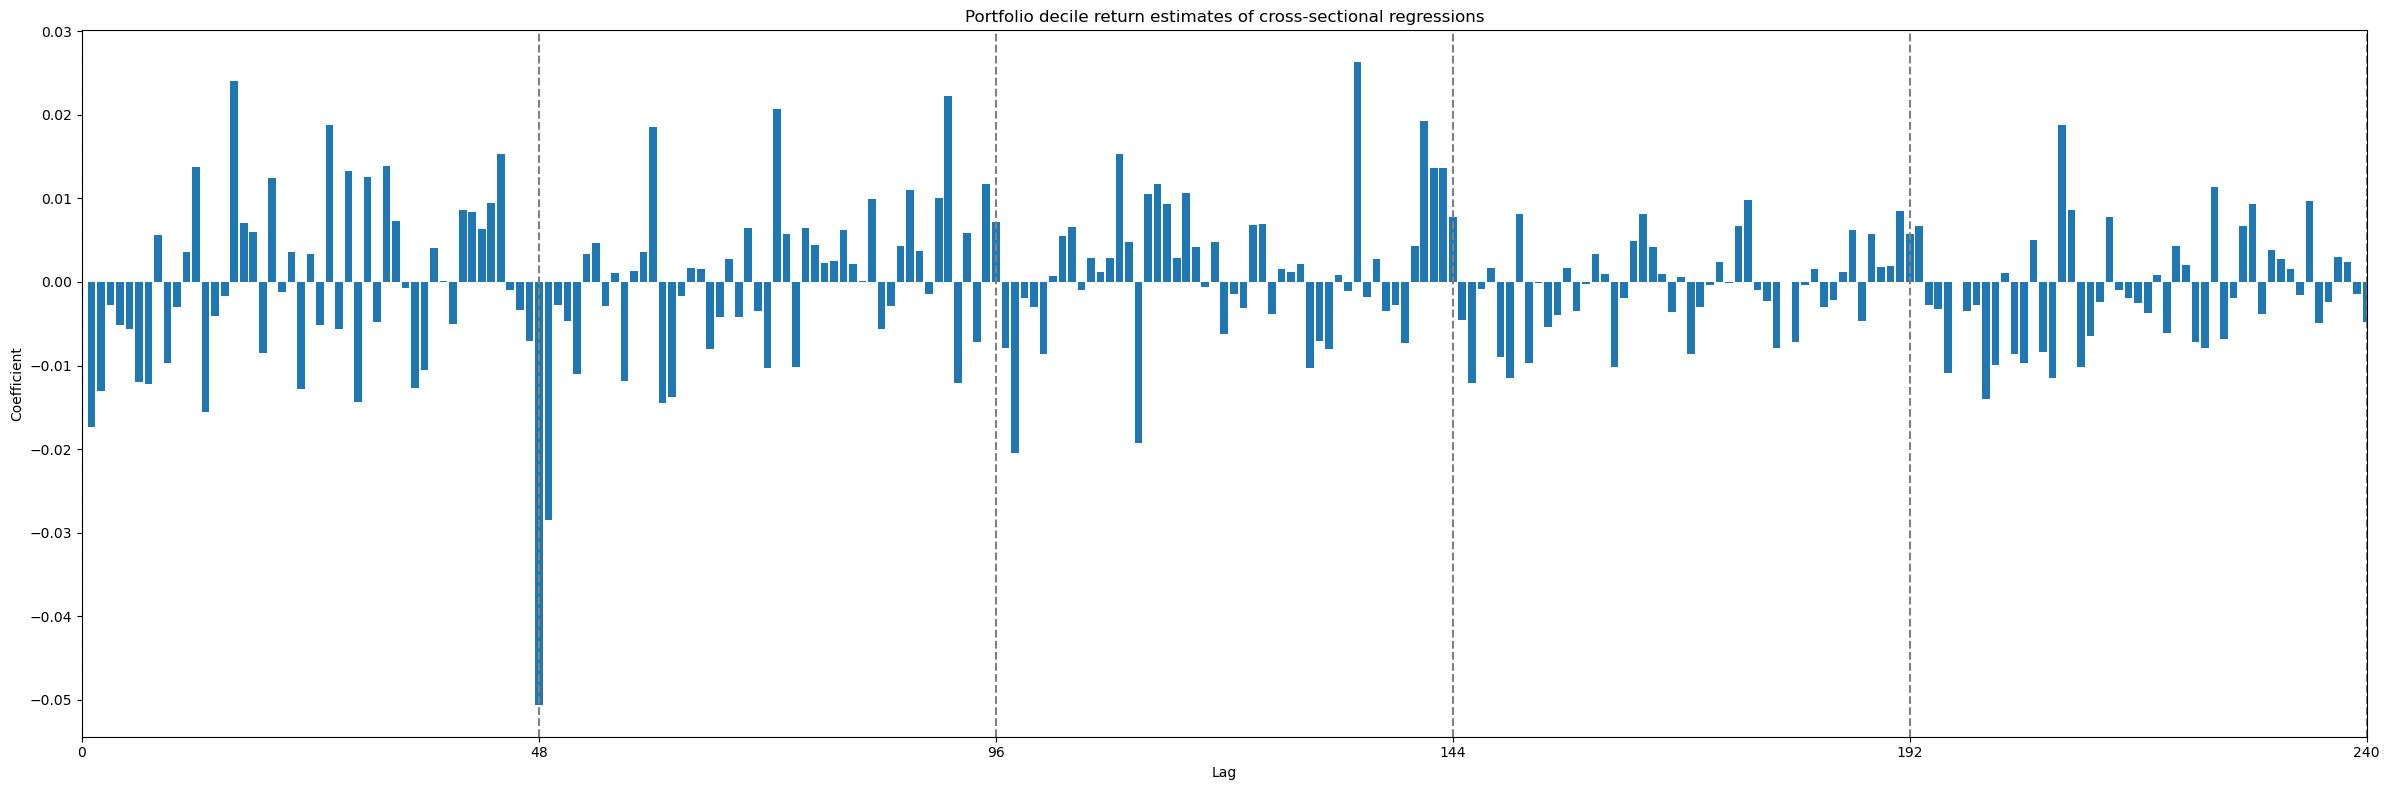

In [305]:
lags = list(df_coef.columns)
gamma = np.array(df_coef.mean())
gamma = np.insert(gamma, 0, 0)
lags = np.array([int(re.findall('\d+', lag)[0]) for lag in lags])
lags = np.insert(lags, 0, 0)
# Create a bar plot
gamma = gamma[:337]
lags = lags[:337]
fig, ax = plt.subplots(figsize=(24, 8))
ax.bar(lags, gamma)
ax.set_ylabel('Coefficient')
ax.set_xlabel('Lag')
# set the y limit
# ax.set_ylim(-0.15, 0.15)
# set the x ticks
ax.set_xticks(lags[::48])
ax.set_xlim(lags.min(), lags.max())
# insert vertical lines for plot
xticks = ax.get_xticks()
for xtick in xticks:
    ax.axvline(x=xtick, color='gray', linestyle='--')
ax.set_title('Portfolio decile return estimates of cross-sectional regressions')
fig.tight_layout()
plt.show()
fig.savefig('portfolio_estimate.jpg')

Now, find the t-statistic for the portfolio

In [296]:
df_tvalue = pd.DataFrame()
cryptos = ['btc', 'eth', 'doge', 'sol', 'fil', 'ltc', 'bnb', 'shib', 'xrp', 'aave']
for c in cryptos:
    tvalue = globals().get(f"tvalue_{c}")
    temp = pd.DataFrame(tvalue[1:]).transpose()
    replace = c.upper() + '_'
    temp = temp.rename(columns=lambda x: x.replace(replace, '') if replace in x else x)
    df_tvalue = pd.concat([df_tvalue, temp])

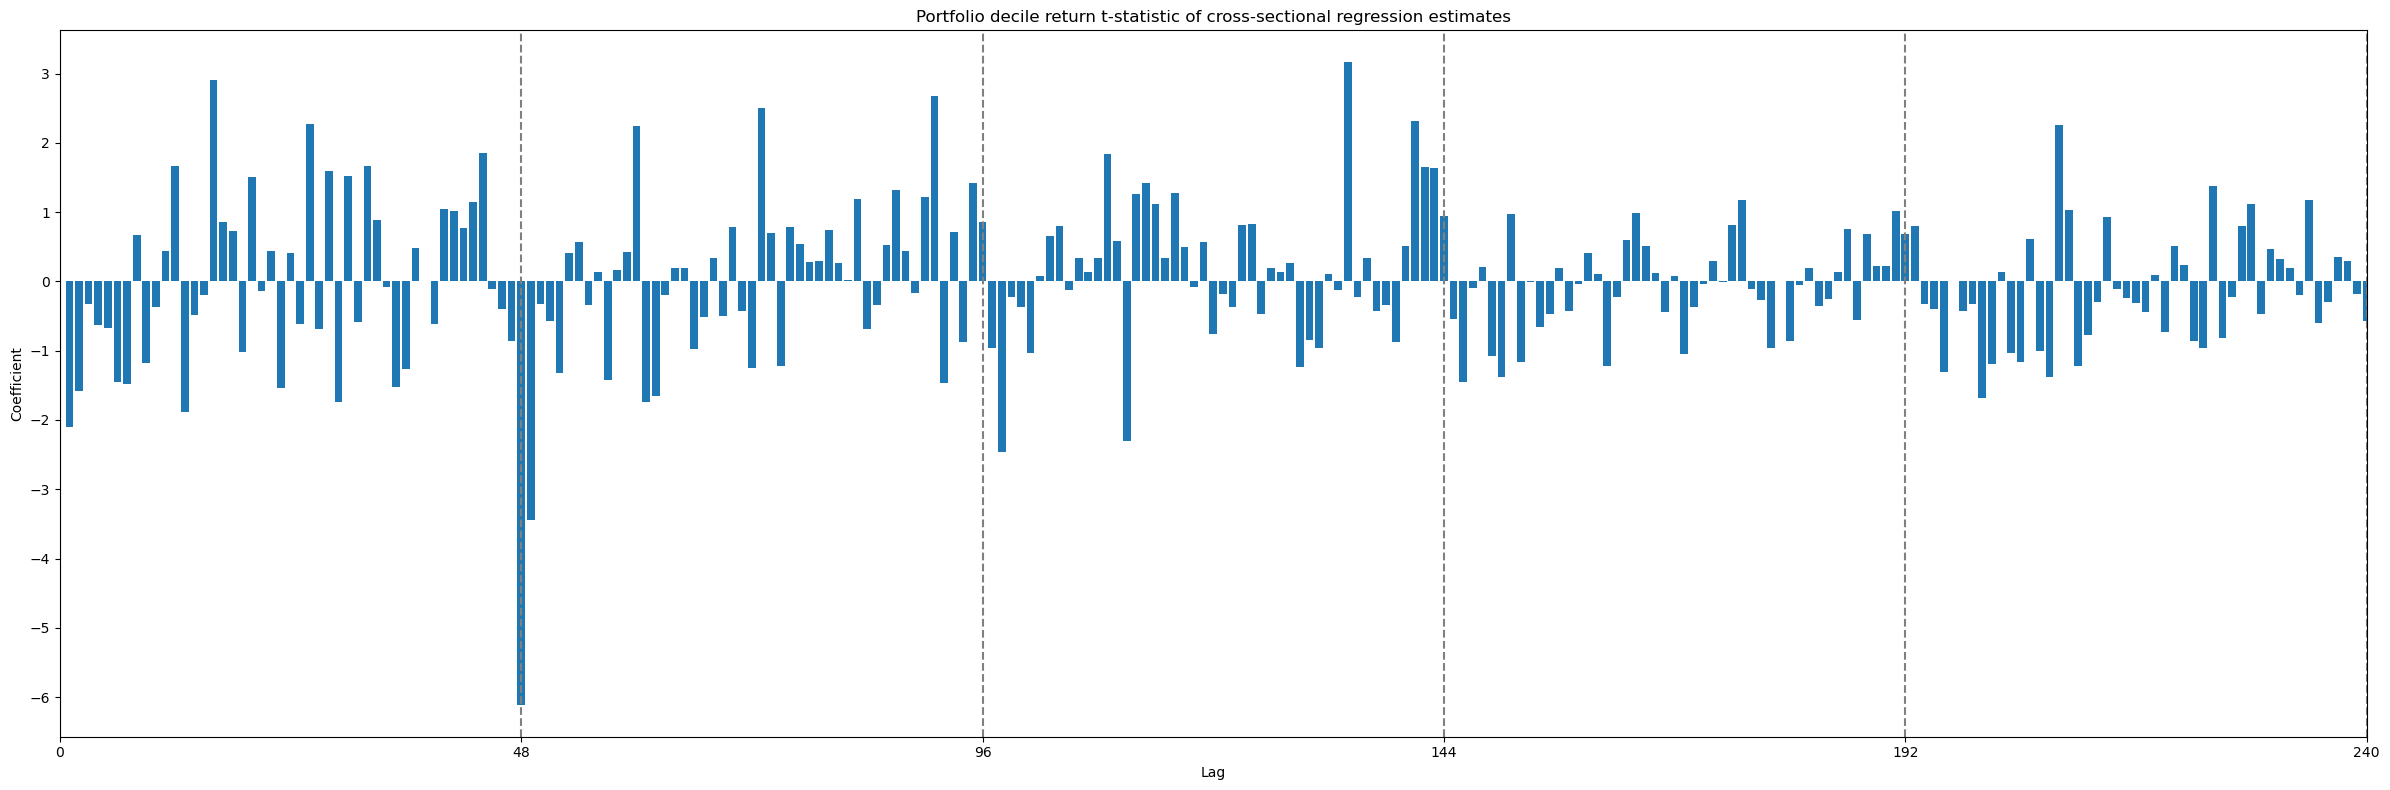

In [306]:
lags = list(df_tvalue.columns)
gamma = np.array(df_tvalue.mean())
gamma = np.insert(gamma, 0, 0)
lags = np.array([int(re.findall('\d+', lag)[0]) for lag in lags])
lags = np.insert(lags, 0, 0)
# Create a bar plot
gamma = gamma[:337]
lags = lags[:337]
fig, ax = plt.subplots(figsize=(24, 8))
ax.bar(lags, gamma)
ax.set_ylabel('Coefficient')
ax.set_xlabel('Lag')
# set the y limit
# ax.set_ylim(-1, 1)
# set the x ticks
ax.set_xticks(lags[::48])
ax.set_yticks([i for i in range(-6, 4)])
ax.set_xlim(lags.min(), lags.max())
# insert vertical lines for plot
xticks = ax.get_xticks()
for xtick in xticks:
    ax.axvline(x=xtick, color='gray', linestyle='--')
ax.set_title('Portfolio decile return t-statistic of cross-sectional regression estimates')
fig.tight_layout()
plt.show()
fig.savefig('portfolio_tvalue.jpg')

Find 1 day estimates and t-statistics seperately for other 9 cryptos

In [421]:
# build a coefficient dataframe for 9 cryptos
df_coef_ = df_coef.set_index(np.char.upper(np.array(cryptos)))
df_coef_ = df_coef_.transpose()
lags = np.array([int(re.findall('\d+', lag)[0]) for lag in list(df_coef_.index)])
lags = np.insert(lags, 0, 0)
lag_0 = pd.DataFrame(columns=np.char.upper(np.array(cryptos)))
lag_0.loc[0] = [0] * 10
df_coef_ = pd.concat([lag_0, df_coef_])
df_coef_ = df_coef_.reset_index(drop=True)
df_coef_ = df_coef_.set_index(lags)
cols = list(df_coef_.columns)
cols.pop(0)

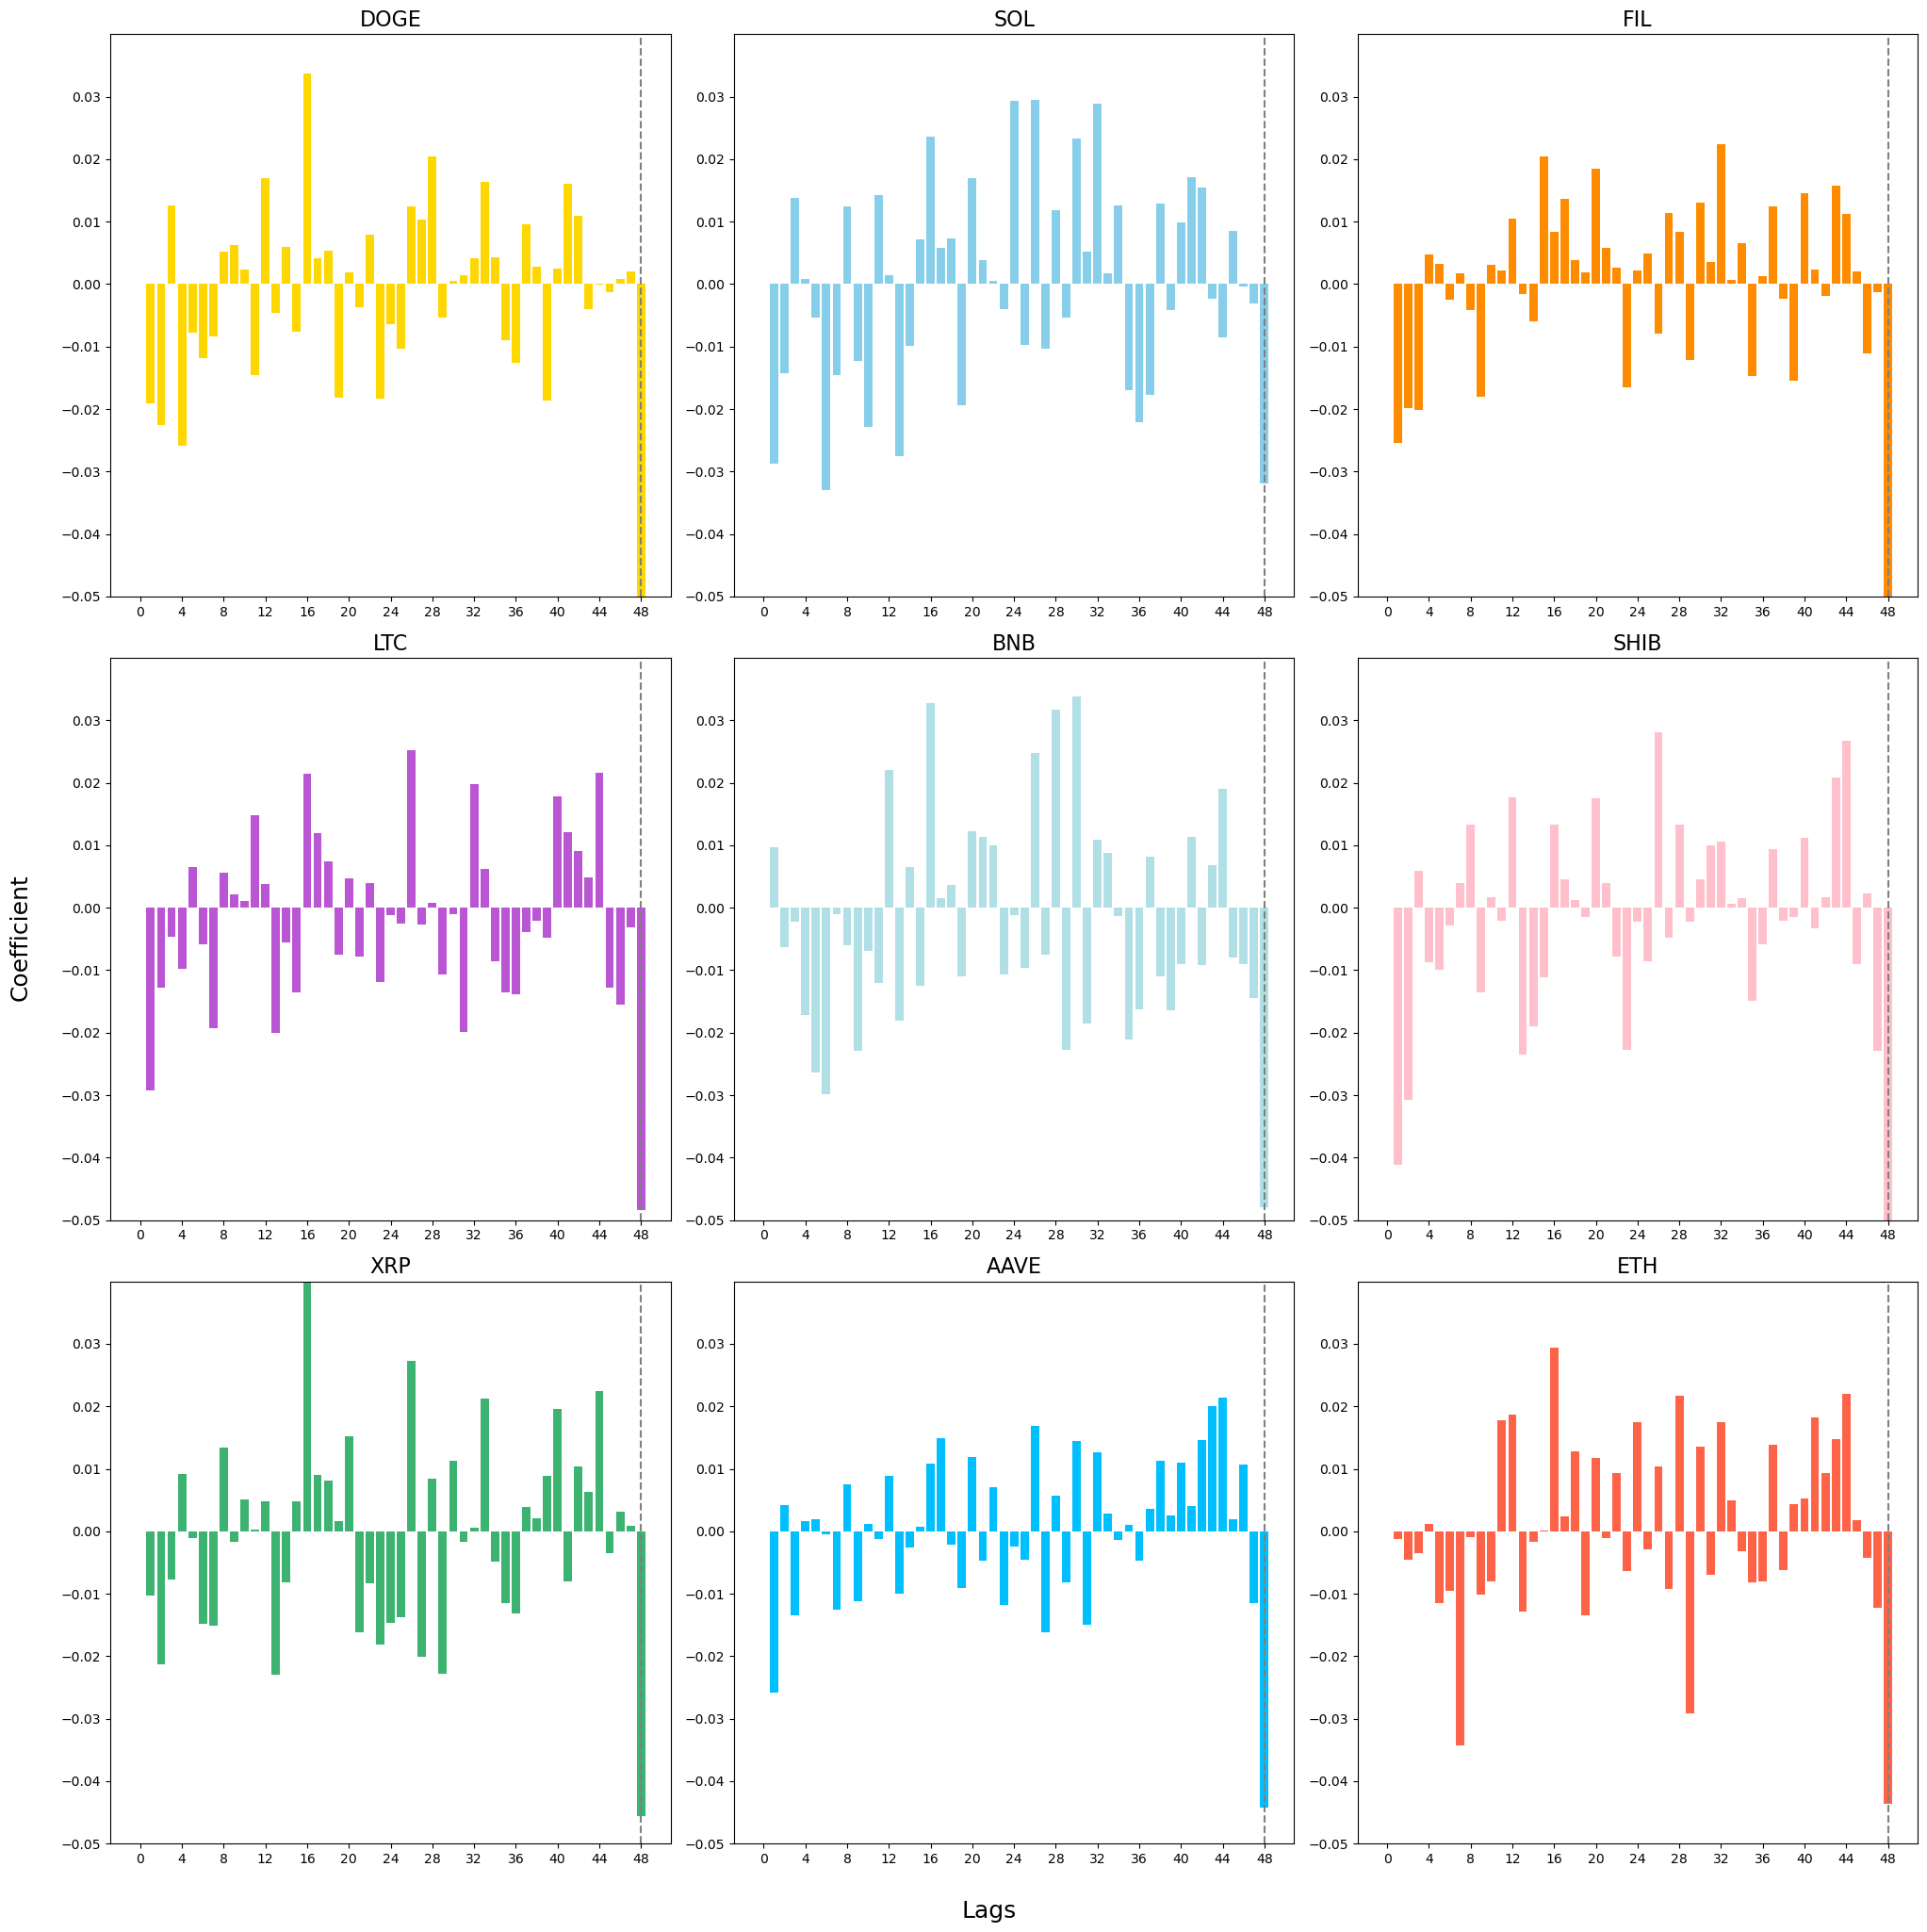

In [530]:
fig, axs = plt.subplots(3, 3, figsize=(20, 20))
colors = ['#FF6347','#FFD700','#87CEEB','#FF8C00','#BA55D3','#B0E0E6','#FFC0CB','#3CB371','#00BFFF'] 
# plot data on each subplot
for i, col in enumerate(cols):
    r, c = divmod(i-1, 3)
    lags = np.array(df_coef_.index)[:49]
    gamma = np.array(df_coef_[col])[:49]
    axs[r, c].bar(lags, gamma, color=colors[i])
    axs[r, c].set_title(col, fontsize=16)
    axs[r, c].set_xticks(lags[::4])
    axs[r, c].set_yticks([i/100 for i in range(-5, 4, 1)])
    axs[r, c].set_ylim(-0.05, 0.04)
    axs[r, c].axvline(x=48, color='gray', linestyle='--')
    
# set the x and y-axis labels for the entire plot
fig.text(0.5, -0.02, 'Lags', ha='center', fontsize=18)
fig.text(-0.02, 0.5, 'Coefficient', va='center', rotation='vertical', fontsize=18)

# adjust the space between subplots
plt.tight_layout()
plt.show()
fig.savefig('1day_estimate_for_others.jpg')

In [525]:
df_tvalue_ = df_tvalue.set_index(np.char.upper(np.array(cryptos)))
df_tvalue_ = df_tvalue_.transpose()
lags = np.array([int(re.findall('\d+', lag)[0]) for lag in list(df_tvalue_.index)])
lags = np.insert(lags, 0, 0)
lag_0 = pd.DataFrame(columns=np.char.upper(np.array(cryptos)))
lag_0.loc[0] = [0] * 10
df_tvalue_ = pd.concat([lag_0, df_tvalue_])
df_tvalue_ = df_tvalue_.reset_index(drop=True)
df_tvalue_ = df_tvalue_.set_index(lags)
cols = list(df_tvalue_.columns)
cols.pop(0)

'BTC'

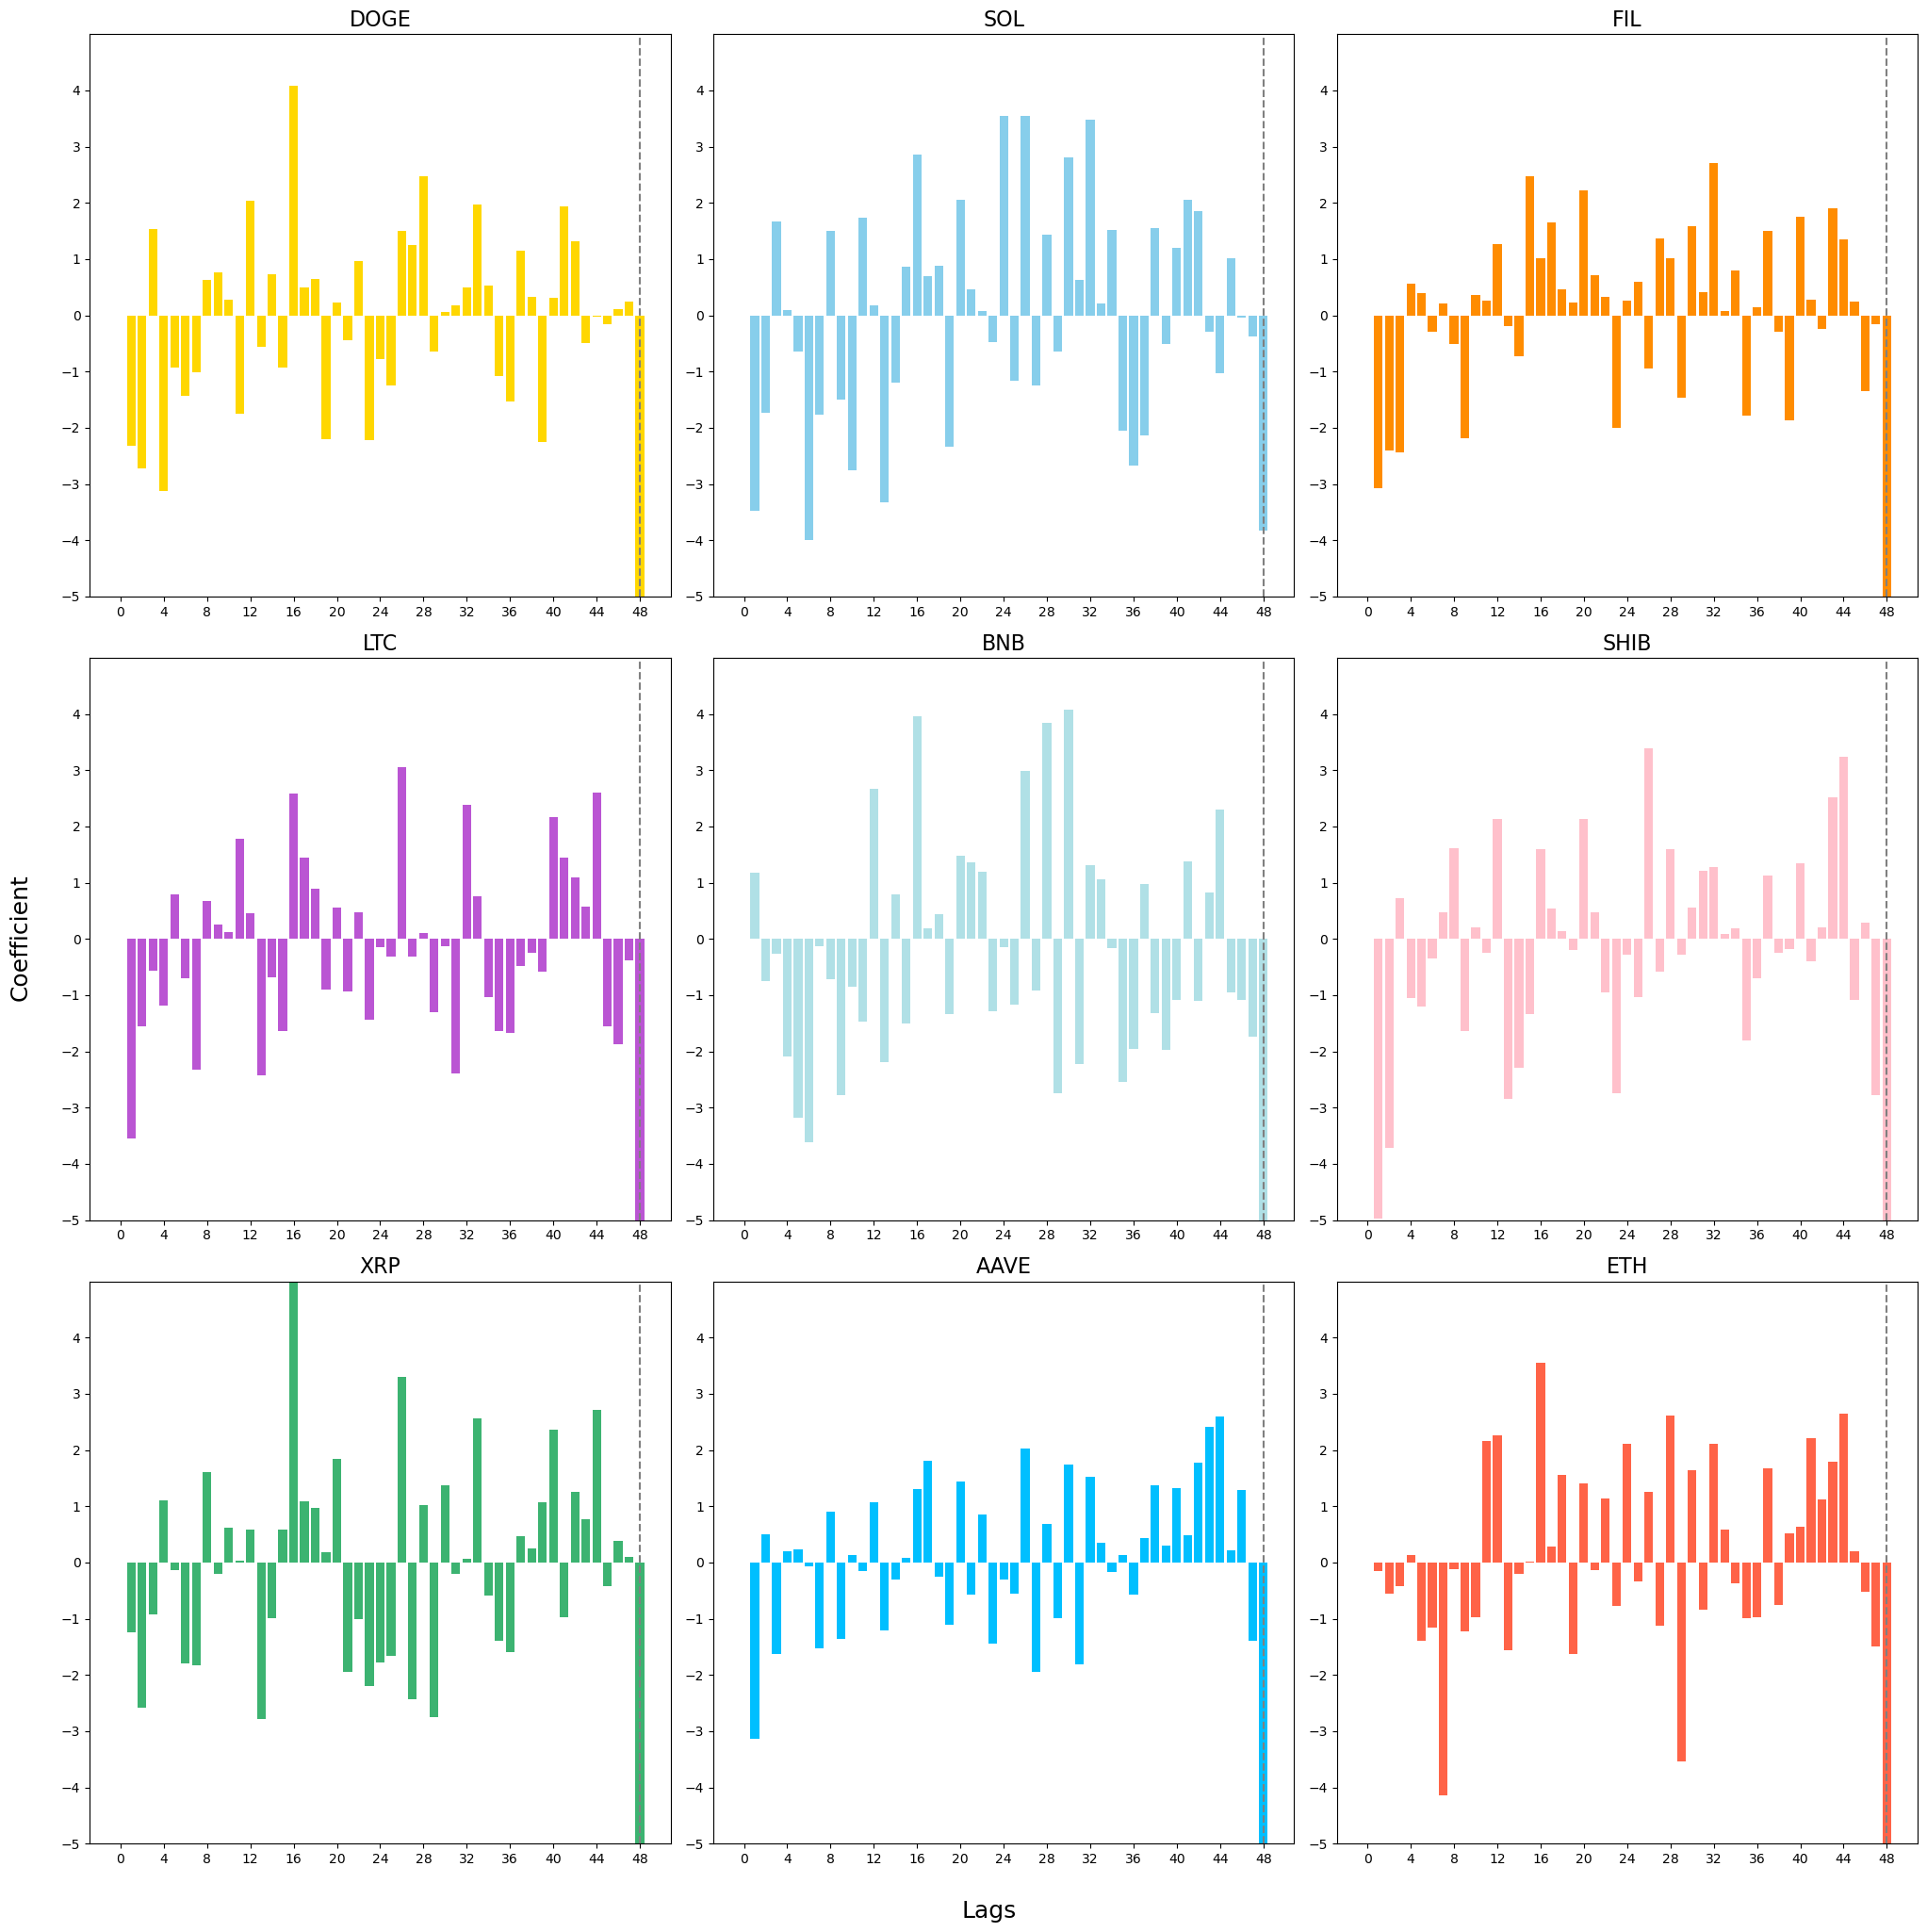

In [531]:
fig, axs = plt.subplots(3, 3, figsize=(20, 20))
colors = ['#FF6347','#FFD700','#87CEEB','#FF8C00','#BA55D3','#B0E0E6','#FFC0CB','#3CB371','#00BFFF'] 
# plot data on each subplot
for i, col in enumerate(cols):
    r, c = divmod(i-1, 3)
    lags = np.array(df_tvalue_.index)[:49]
    gamma = np.array(df_tvalue_[col])[:49]
    axs[r, c].bar(lags, gamma, color=colors[i])
    axs[r, c].set_title(col, fontsize=16)
    axs[r, c].set_xticks(lags[::4])
    axs[r, c].set_yticks([i for i in range(-5, 5, 1)])
    axs[r, c].set_ylim(-5, 5)
    axs[r, c].axvline(x=48, color='gray', linestyle='--')
    
# set the x and y-axis labels for the entire plot
fig.text(0.5, -0.02, 'Lags', ha='center', fontsize=18)
fig.text(-0.02, 0.5, 'Coefficient', va='center', rotation='vertical', fontsize=18)

# adjust the space between subplots
plt.tight_layout()
plt.show()
fig.savefig('1day_tvalue_for_others.jpg')

### Analysis for volume

In [538]:
df_volumes.tail()

,BTC_volume,ETH_volume,DOGE_volume,SOL_volume,FIL_volume,LTC_volume,BNB_volume,SHIB_volume,XRP_volume,AAVE_volume
timestamp,,,,,,,,,,
2022-12-31 22:00:00,2812.80041,5684.9945,7531127.0,54799.38,37882.41,10266.808,2125.365,1.162072e+10,1374726.0,642.504
2022-12-31 22:30:00,1429.28009,1808.4262,5706807.0,23306.71,27606.02,6981.073,2095.811,1.110425e+10,1650007.0,103.305
2022-12-31 23:00:00,2251.36363,4632.4586,9978237.0,68897.38,25277.08,4610.185,2976.636,2.677368e+10,1982168.0,1401.648
2022-12-31 23:30:00,2033.64546,1776.7905,12332446.0,46226.78,21479.15,3086.955,6119.630,3.840573e+10,3020313.0,2971.213
2023-01-01 00:00:00,2048.58468,1254.4771,8931468.0,63557.64,14748.67,12437.193,4120.344,3.214724e+10,3392706.0,3008.915


In [571]:
# shift k lags
df_volumes['BTC_vol_lag1'] = df_volumes['BTC_volume'].shift()
df_btc_vol = df_volumes[['BTC_volume', 'BTC_vol_lag1']]
df_btc_vol.rename(columns={'BTC_volume': 'BTC_vol_lag0'}, inplace=True)
for i in range(2, 1441):
    lag = "BTC_vol_lag" + str(i)
    df_btc_vol[lag] = df_volumes['BTC_volume'].shift(i)

In [572]:
# reverse dataset for better understandding of lags
df_btc_vol_r = df_btc_vol.iloc[::-1]
# remove missing value
df_btc_vol_r = df_btc_vol_r.dropna()
# get first month data
df_btc_vol_1m = df_btc_vol_r.loc['2022-12-01 00:00:00':]

In [573]:
# Specify the dependent and independent variables
log_cols = list(df_btc_vol_1m.columns)
y = df_btc_vol_1m[log_cols.pop(0)]
X = df_btc_vol_1m[log_cols]
X = sm.add_constant(X) 

In [574]:
# run regression for volumes
BTC_lag1440_vol_1m_reg = sm.OLS(y, X).fit()

Plot Bitcoin volume estimates of cross-sectional regressions

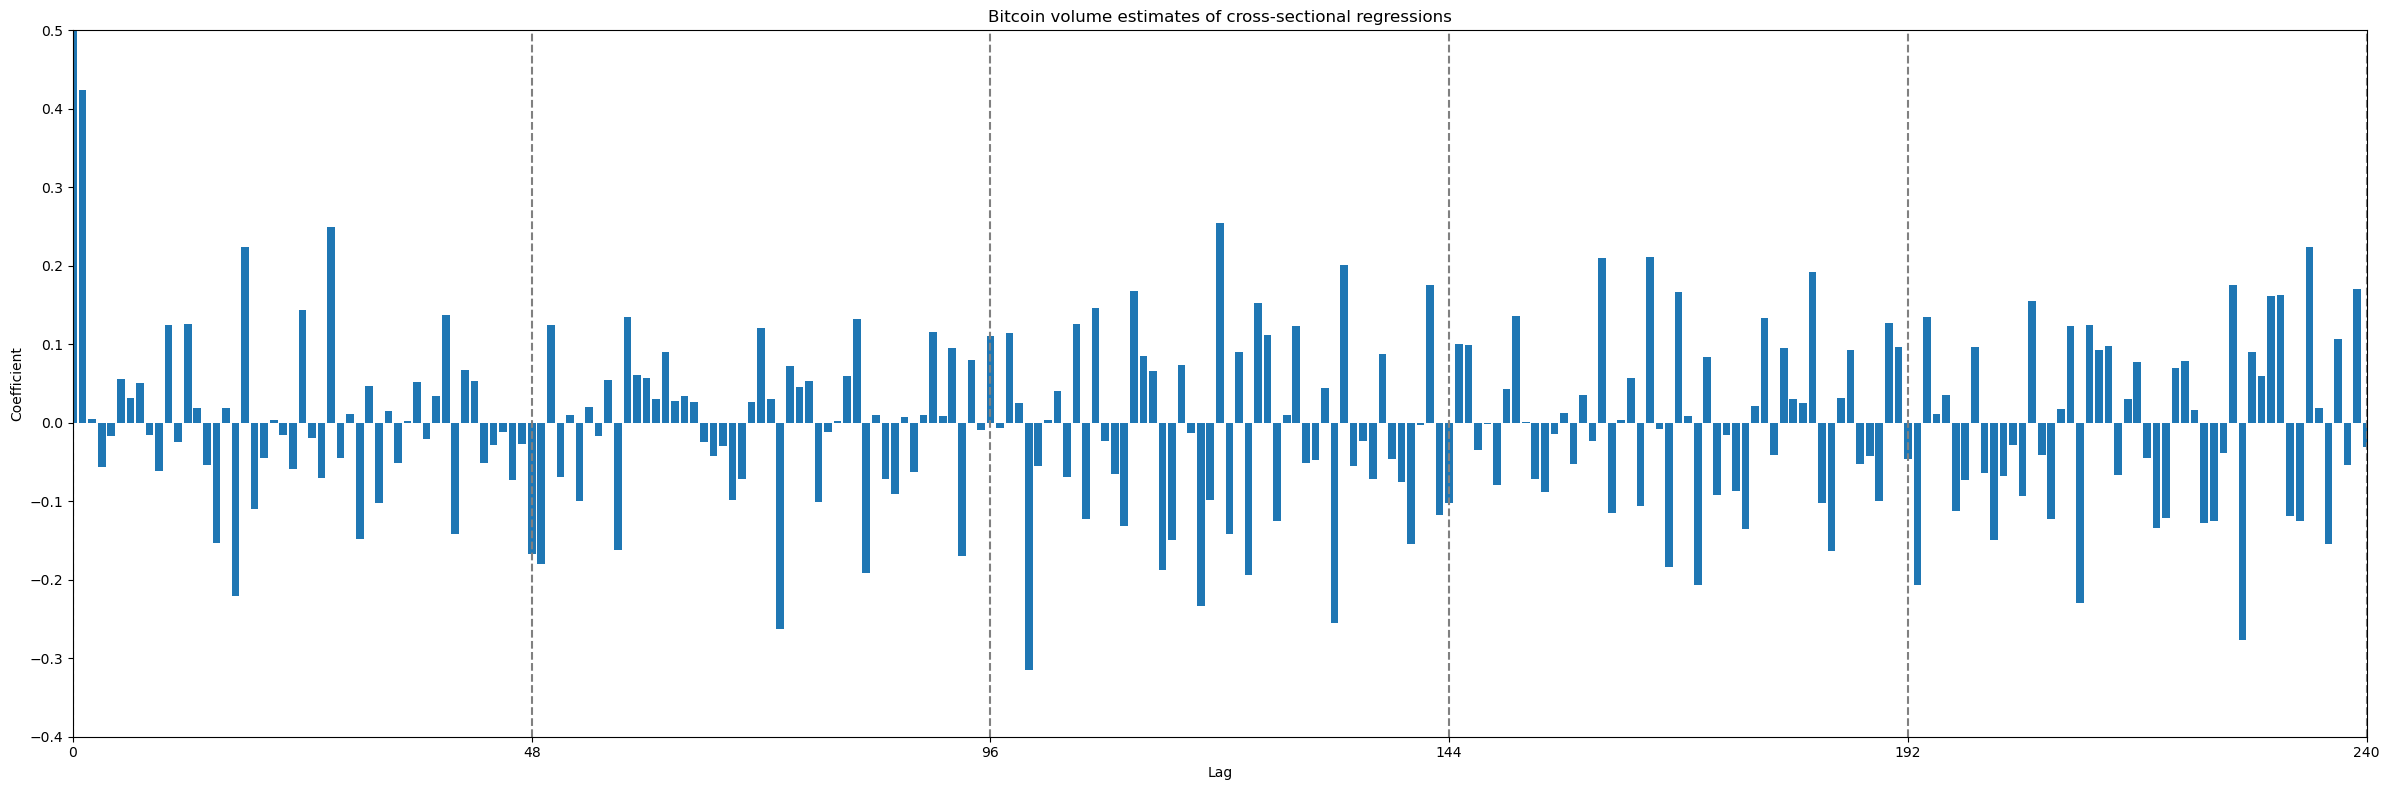

In [575]:
# Extract coefficients
coef = BTC_lag1440_vol_1m_reg.params
# Delete intercept coef
gamma = np.delete(coef.values, 0)
gamma = np.insert(gamma, 0, 1)
lags = np.delete(coef.index, 0)
lags = np.array([int(re.findall('\d+', lag)[0]) for lag in lags])
lags = np.insert(lags, 0, 0)
# Create a bar plot
gamma = gamma[:241]
lags = lags[:241]
fig, ax = plt.subplots(figsize=(24, 8))
ax.bar(lags, gamma)
ax.set_ylabel('Coefficient')
ax.set_xlabel('Lag')
# set the y limit
ax.set_ylim(-0.4, 0.5)
# set the x ticks
ax.set_xticks(lags[::48])
ax.set_xlim(lags.min(), lags.max())
# insert vertical lines for plot
xticks = ax.get_xticks()
for xtick in xticks:
    ax.axvline(x=xtick, color='gray', linestyle='--')
ax.set_title('Bitcoin volume estimates of cross-sectional regressions')
fig.tight_layout()
plt.show()

In [627]:
# run simple regression for Bitcoin volumes for every time slot till lag 336 (7days)
cols = list(df_btc_vol_r.columns)
coef, tvalue = [], []
for i in range(1, 337):
    y = df_btc_vol_r[cols[0]]
    X = df_btc_vol_r[cols[i]]
    BTC_lag1440_vol_s_reg = sm.OLS(y, X).fit()
    coef.append(BTC_lag1440_vol_s_reg.params)
    tvalue.append(BTC_lag1440_vol_s_reg.tvalues)

In [636]:
gamma = np.array(coef)
tstat = np.array(tvalue)
lags = np.array([int(re.findall('\d+', col)[0]) for col in cols])
lags = np.delete(lags, 0)[0:336]

In [645]:
df_btc_coef = pd.DataFrame(gamma, index=lags, columns=['Coefficient'])
df_btc_tstat = pd.DataFrame(tstat, index=lags, columns=['t-Statistic'])
df_btc_table = pd.merge(df_btc_coef, df_btc_tstat, left_index=True, right_index=True)
df_btc_table = df_btc_table.reset_index().rename(columns={'index': 'Lag'})

In [666]:
# split DataFrame into smaller DataFrames of size 48
df_btc_table_48s = np.array_split(df_btc_table, len(df_btc_table) // 48)

In [685]:
df_btc_merged =  df_btc_table_48s[0]
df_btc_merged = df_btc_merged.reset_index(drop=True)
for i in range(1, len(df_btc_table_48s)):
    df_temp = df_btc_table_48s[i].reset_index(drop=True)
    df_btc_merged = pd.merge(df_btc_merged, df_temp, left_index=True, right_index=True)
df_btc_merged = df_btc_merged.rename(columns=lambda x: x.replace('_x', '').replace('_y', ''))

In [687]:
df_btc_merged.to_csv('bitcoin_table_336.csv', index=False)

In [688]:
df_btc_merged.head()

,Lag,Coefficient,t-Statistic,Lag,Coefficient,t-Statistic,Lag,Coefficient,t-Statistic,Lag,...,t-Statistic,Lag,Coefficient,t-Statistic,Lag,Coefficient,t-Statistic,Lag,Coefficient,t-Statistic
0,1,0.497321,72.690317,49,0.000003,0.000423,97,0.000004,0.000532,145,...,0.000368,193,0.000004,0.000496,241,0.000003,0.000370,289,0.000002,0.000275
1,2,0.000002,0.000210,50,0.000004,0.000562,98,0.000003,0.000440,146,...,0.000418,194,0.000004,0.000490,242,0.000003,0.000406,290,0.000002,0.000241
2,3,0.000002,0.000222,51,0.000005,0.000603,99,0.000004,0.000481,147,...,0.000533,195,0.000004,0.000515,243,0.000003,0.000379,291,0.000002,0.000216
3,4,0.000002,0.000305,52,0.000005,0.000577,100,0.000003,0.000437,148,...,0.000540,196,0.000005,0.000584,244,0.000003,0.000413,292,0.000002,0.000258
4,5,0.000002,0.000309,53,0.000004,0.000516,101,0.000003,0.000363,149,...,0.000699,197,0.000004,0.000539,245,0.000003,0.000428,293,0.000002,0.000256


In [689]:
log_cols = list(df_btc_vol_r.columns)
y = df_btc_vol_r[log_cols.pop(0)]
X = df_btc_vol_r[log_cols]
X = sm.add_constant(X)
# run regression for volumes
BTC_lag1440_vol_reg = sm.OLS(y, X).fit()

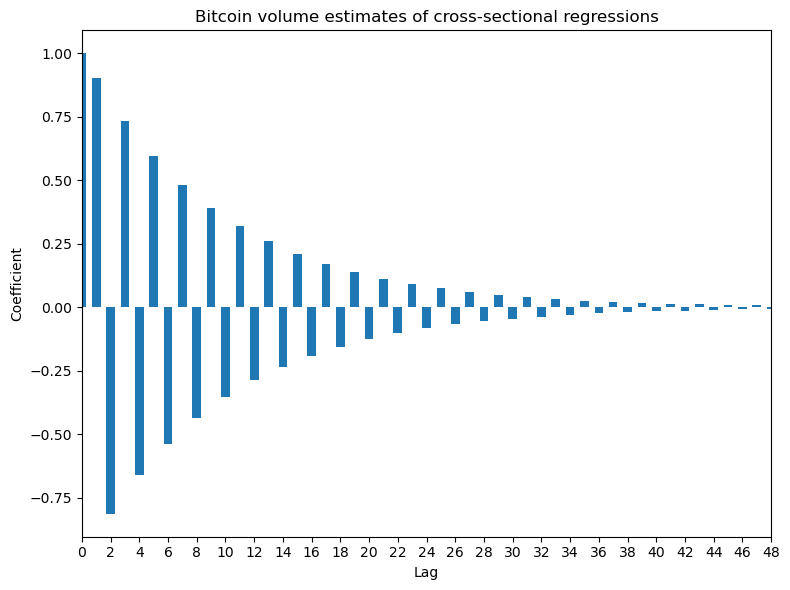

In [690]:
# Extract coefficients
coef = BTC_lag1440_vol_reg.params
# Delete intercept coef
gamma = np.delete(coef.values, 0)
gamma = np.insert(gamma, 0, 1)
lags = np.delete(coef.index, 0)
lags = np.array([int(re.findall('\d+', lag)[0]) for lag in lags])
lags = np.insert(lags, 0, 0)
# Create a bar plot
gamma = gamma[:49]
lags = lags[:49]
fig, ax = plt.subplots(figsize=(8, 6))
ax.bar(lags, gamma, width = 0.6)
ax.set_ylabel('Coefficient')
ax.set_xlabel('Lag')
# set the x ticks
ax.set_xticks(lags[::2])
ax.set_xlim(lags.min(), lags.max())
ax.set_title('Bitcoin volume estimates of cross-sectional regressions')
fig.tight_layout()
plt.show()

#### ETH

In [47]:
# shift k lags
df_volumes['ETH_vol_lag1'] = df_volumes['ETH_volume'].shift()
df_eth_vol = df_volumes[['ETH_volume', 'ETH_vol_lag1']]
df_eth_vol.rename(columns={'ETH_volume': 'ETH_vol_lag0'}, inplace=True)
for i in range(2, 1441):
    lag = "ETH_vol_lag" + str(i)
    df_eth_vol[lag] = df_volumes['ETH_volume'].shift(i)
# reverse dataset for better understandding of lags
df_eth_vol_r = df_eth_vol.iloc[::-1]
# remove missing value
df_eth_vol_r = df_eth_vol_r.dropna()
# get first month data
df_eth_vol_1m = df_eth_vol_r.loc['2022-12-01 00:00:00':]
# Specify the dependent and independent variables
log_cols = list(df_eth_vol_1m.columns)
y = df_eth_vol_1m[log_cols.pop(0)]
X = df_eth_vol_1m[log_cols]
X = sm.add_constant(X) 
# run regression for volumes
ETH_lag1440_vol_1m_reg = sm.OLS(y, X).fit()

# Plot Ethereum volume estimates of cross-sectional regressions

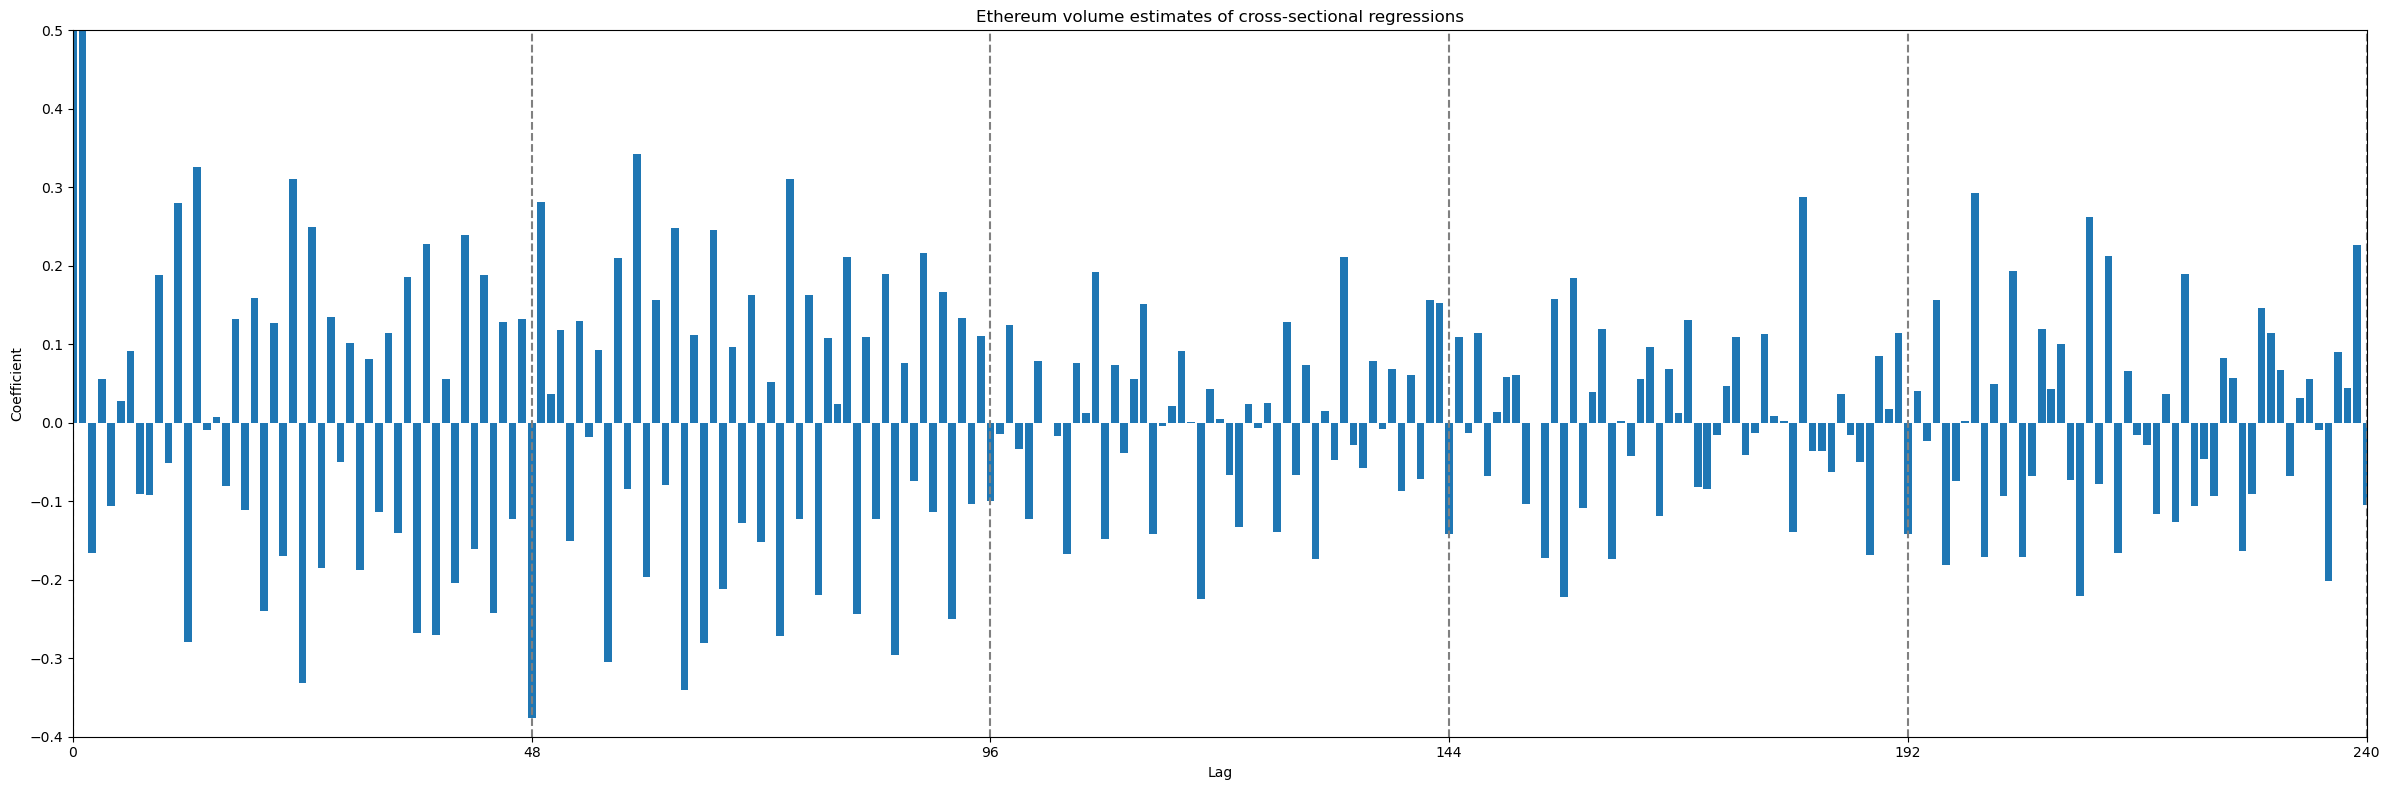

In [48]:
# Extract coefficients
coef = ETH_lag1440_vol_1m_reg.params
# Delete intercept coef
gamma = np.delete(coef.values, 0)
gamma = np.insert(gamma, 0, 1)
lags = np.delete(coef.index, 0)
lags = np.array([int(re.findall('\d+', lag)[0]) for lag in lags])
lags = np.insert(lags, 0, 0)
# Create a bar plot
gamma = gamma[:241]
lags = lags[:241]
fig, ax = plt.subplots(figsize=(24, 8))
ax.bar(lags, gamma)
ax.set_ylabel('Coefficient')
ax.set_xlabel('Lag')
# set the y limit
ax.set_ylim(-0.4, 0.5)
# set the x ticks
ax.set_xticks(lags[::48])
ax.set_xlim(lags.min(), lags.max())
# insert vertical lines for plot
xticks = ax.get_xticks()
for xtick in xticks:
    ax.axvline(x=xtick, color='gray', linestyle='--')
ax.set_title('Ethereum volume estimates of cross-sectional regressions')
fig.tight_layout()
plt.show()

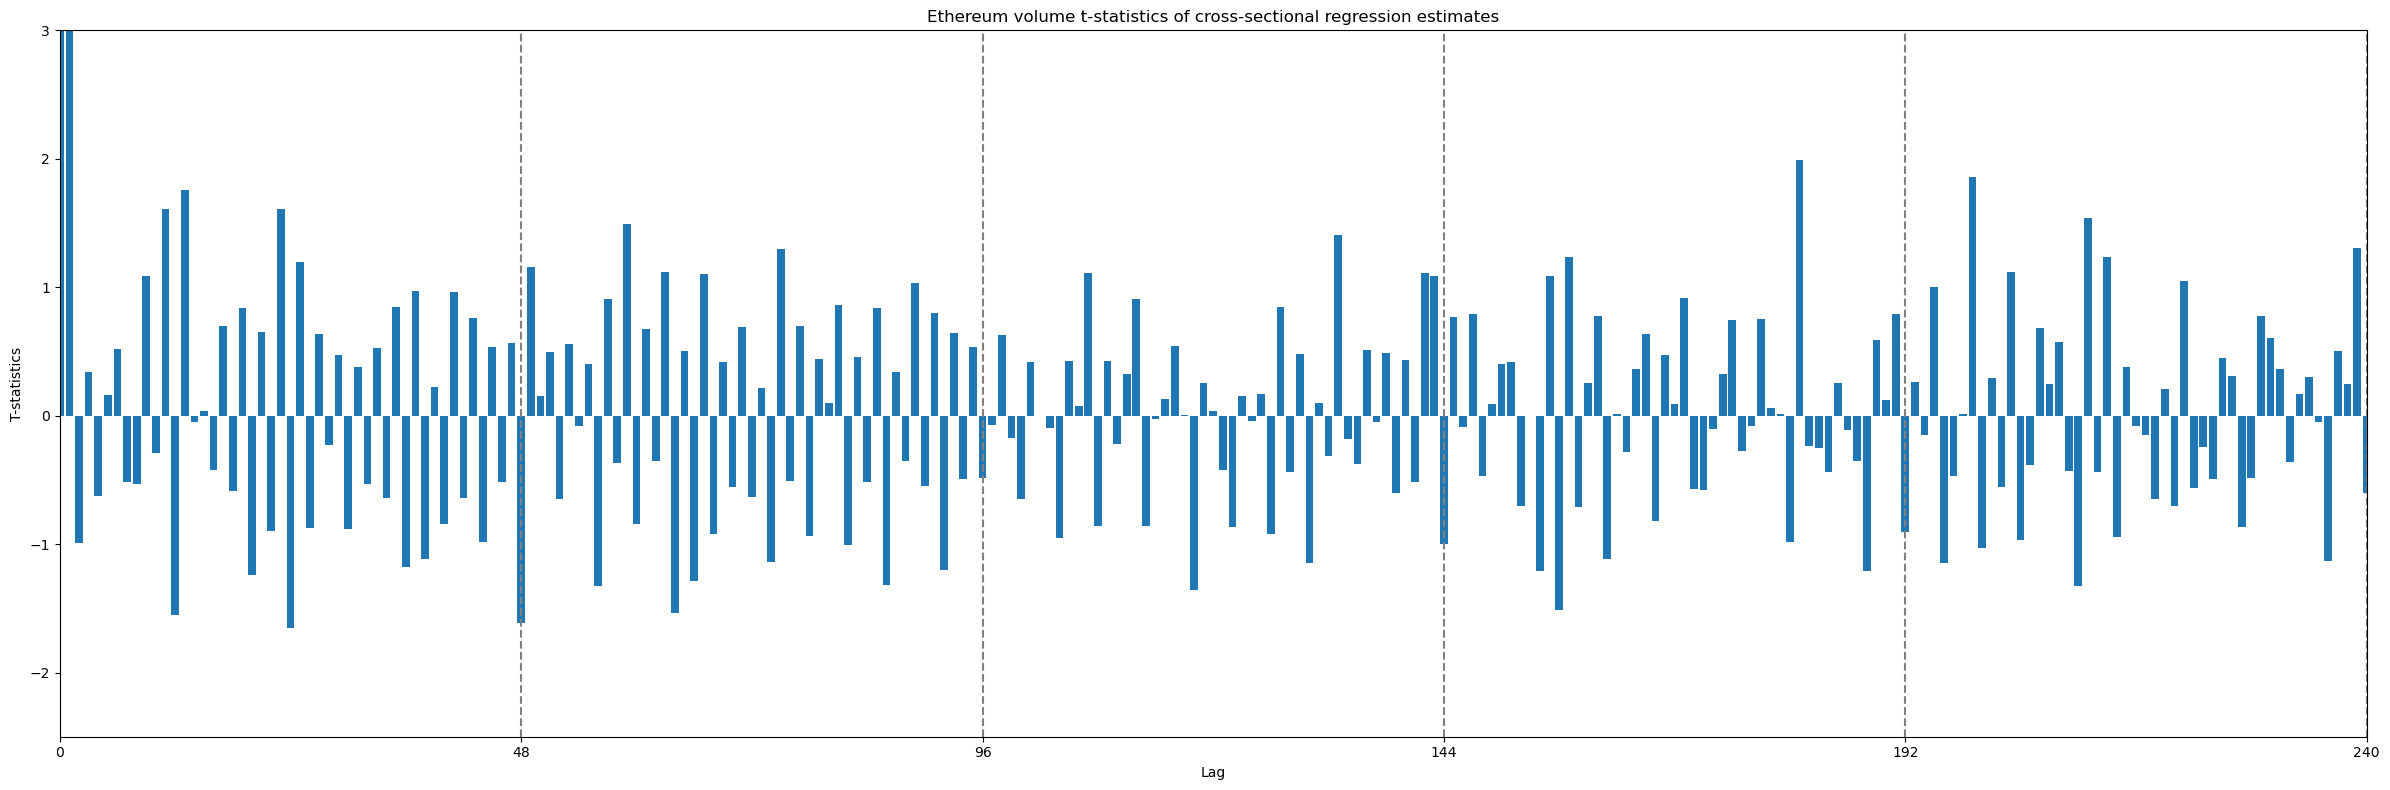

In [49]:
# Extract t-statistic values
tvalue_btc = ETH_lag1440_vol_1m_reg.tvalues
tstats = np.array(tvalue_btc)
# Delete intercept coef
tstats = np.delete(tstats, 0)
tstats = np.insert(tstats, 0, 30.12)
lags = np.delete(coef.index, 0)
lags = np.array([int(re.findall('\d+', lag)[0]) for lag in lags])
lags = np.insert(lags, 0, 0)
# Create a bar plot
tstats = tstats[:241]
lags = lags[:241]
fig, ax = plt.subplots(figsize=(24, 8))
ax.bar(lags, tstats)
ax.set_ylabel('T-statistics')
ax.set_xlabel('Lag')
# set the y limit
ax.set_ylim(-2.5, 3)
# set the x ticks
ax.set_xticks(lags[::48])
ax.set_xlim(lags.min(), lags.max())
# insert vertical lines for plot
xticks = ax.get_xticks()
for xtick in xticks:
    ax.axvline(x=xtick, color='gray', linestyle='--')
ax.set_title('Ethereum volume t-statistics of cross-sectional regression estimates')
fig.tight_layout()
plt.show()

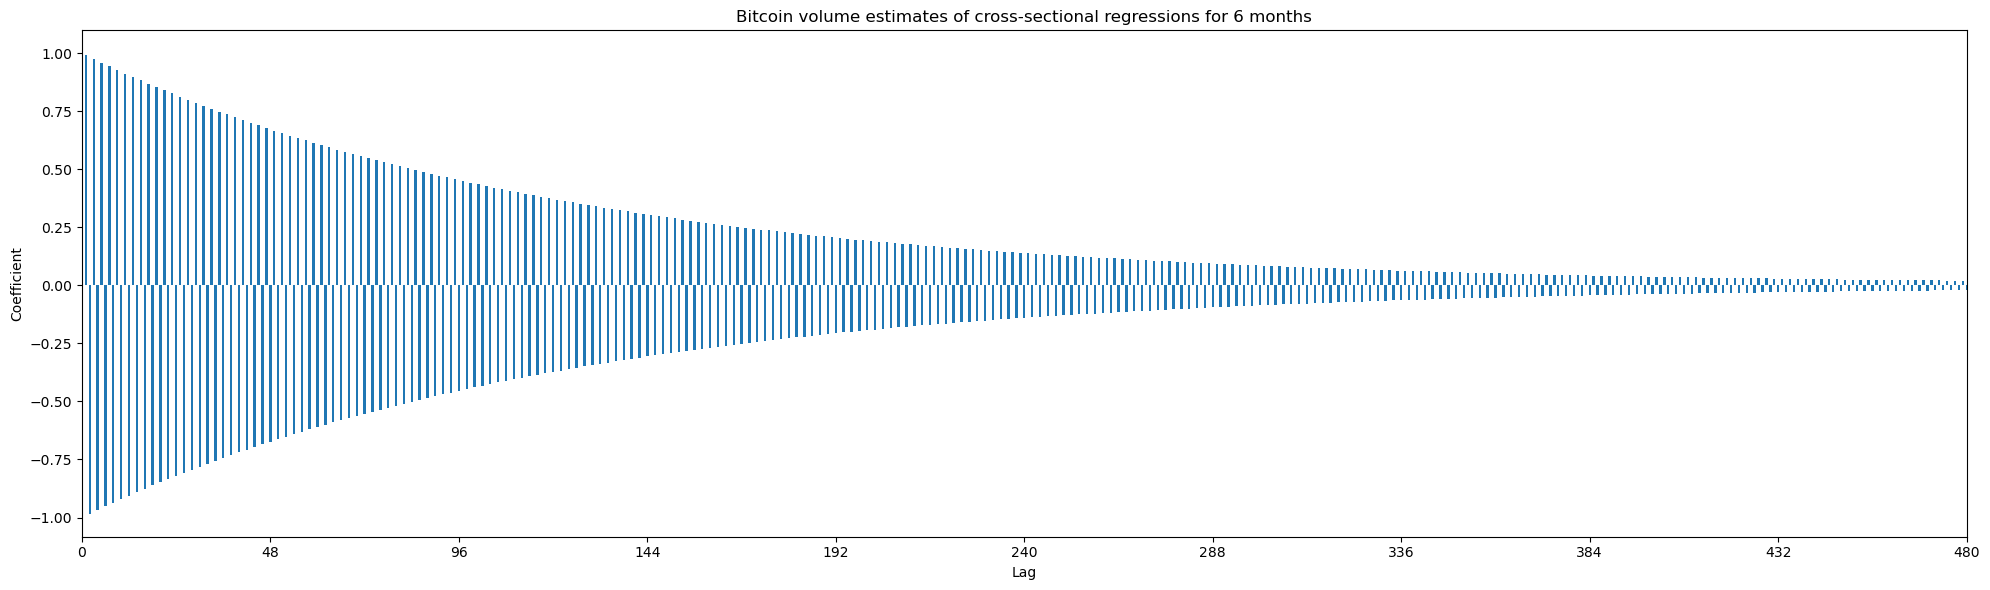

In [50]:
# What if the volume in 6 months
df_eth_vol_6m = df_eth_vol_r.loc['2022-07-01 00:00:00':]
log_cols = list(df_eth_vol_6m.columns)
y = df_eth_vol_6m[log_cols.pop(0)]
X = df_eth_vol_6m[log_cols]
X = sm.add_constant(X)
# run regression for volumes
ETH_lag1440_vol_6m_reg = sm.OLS(y, X).fit()
# Extract coefficients
coef = ETH_lag1440_vol_6m_reg.params
# Delete intercept coef
gamma = np.delete(coef.values, 0)
gamma = np.insert(gamma, 0, 1)
lags = np.delete(coef.index, 0)
lags = np.array([int(re.findall('\d+', lag)[0]) for lag in lags])
lags = np.insert(lags, 0, 0)
# Create a bar plot
gamma = gamma[:481]
lags = lags[:481]
fig, ax = plt.subplots(figsize=(20, 6))
ax.bar(lags, gamma, width = 0.6)
ax.set_ylabel('Coefficient')
ax.set_xlabel('Lag')
# set the x ticks
ax.set_xticks(lags[::48])
ax.set_xlim(lags.min(), lags.max())
ax.set_title('Bitcoin volume estimates of cross-sectional regressions for 6 months')
fig.tight_layout()
plt.show()

#### AAVE  - represents other low volume currency

In [51]:
# shift k lags
df_volumes['AAVE_vol_lag1'] = df_volumes['AAVE_volume'].shift()
df_aave_vol = df_volumes[['AAVE_volume', 'AAVE_vol_lag1']]
df_aave_vol.rename(columns={'AAVE_volume': 'AAVE_vol_lag0'}, inplace=True)
for i in range(2, 1441):
    lag = "AAVE_vol_lag" + str(i)
    df_aave_vol[lag] = df_volumes['AAVE_volume'].shift(i)
# reverse dataset for better understandding of lags
df_aave_vol_r = df_aave_vol.iloc[::-1]
# remove missing value
df_aave_vol_r = df_aave_vol_r.dropna()
# get first month data
df_aave_vol_1m = df_aave_vol_r.loc['2022-12-01 00:00:00':]
# Specify the dependent and independent variables
log_cols = list(df_aave_vol_1m.columns)
y = df_aave_vol_1m[log_cols.pop(0)]
X = df_aave_vol_1m[log_cols]
X = sm.add_constant(X) 
# run regression for volumes
AAVE_lag1440_vol_1m_reg = sm.OLS(y, X).fit()

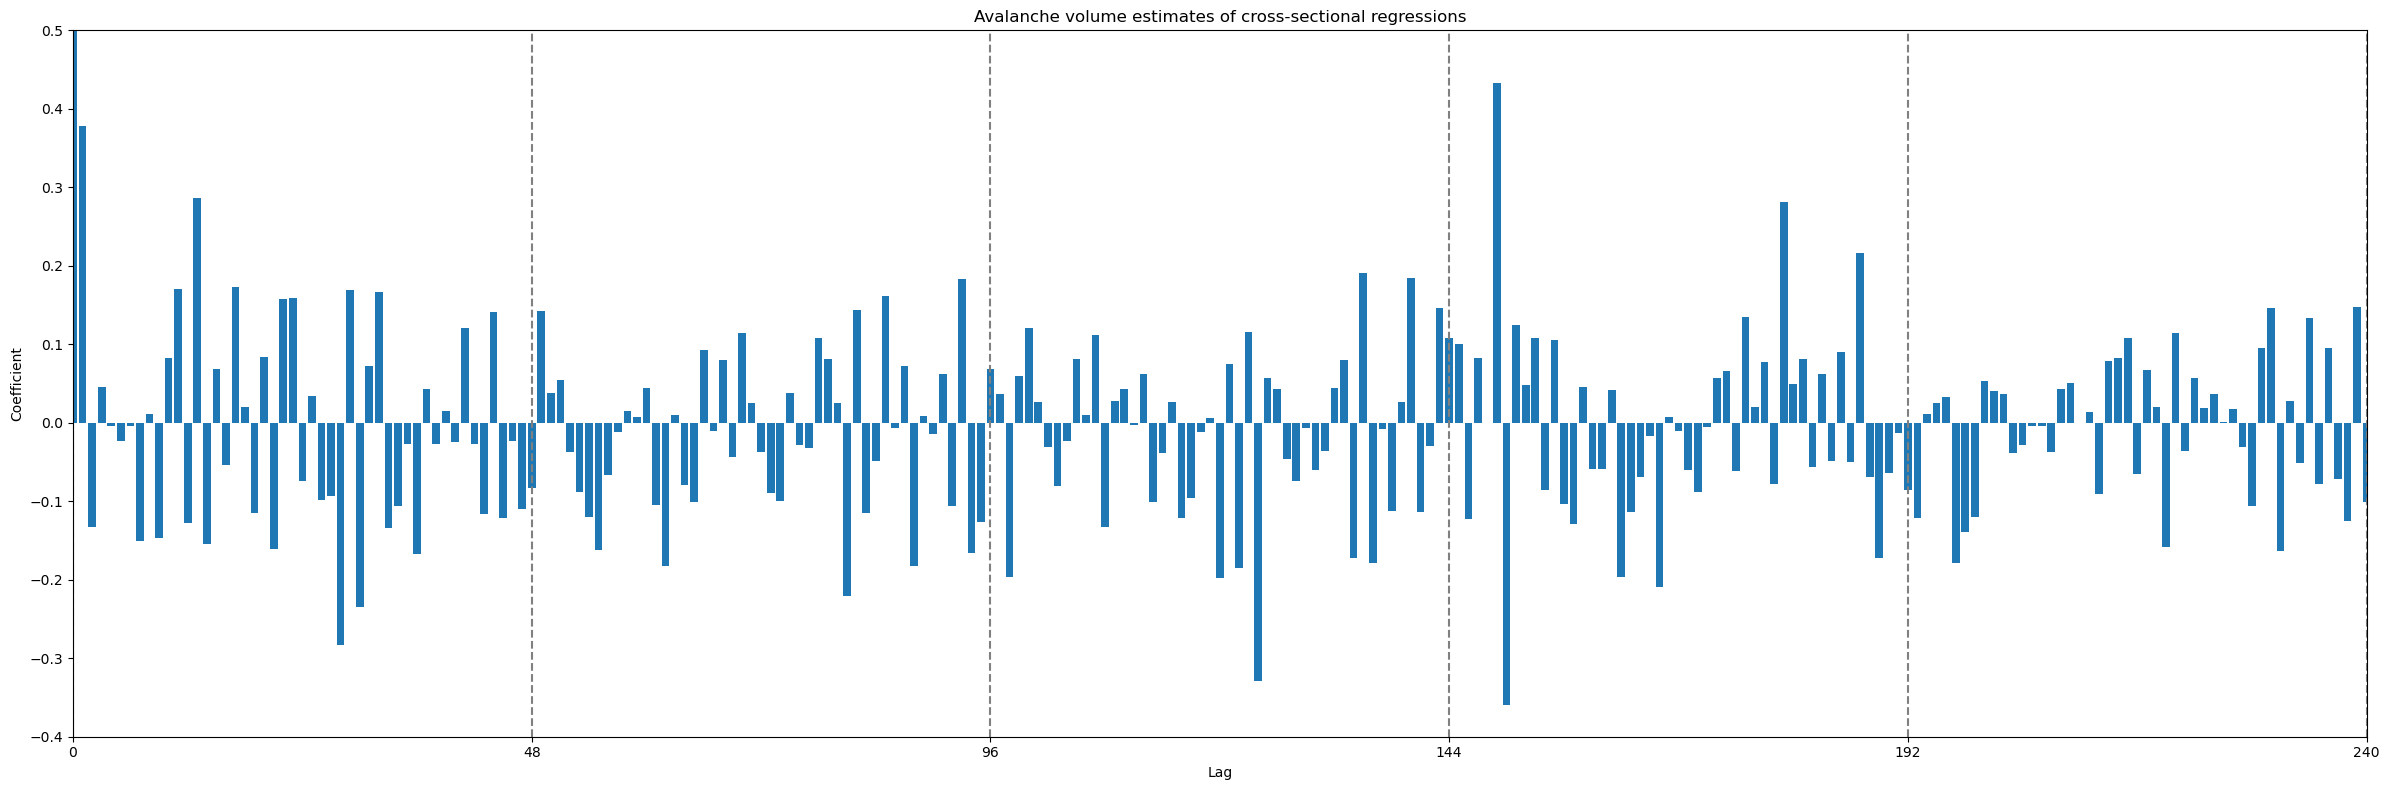

In [52]:
# Extract coefficients
coef = AAVE_lag1440_vol_1m_reg.params
# Delete intercept coef
gamma = np.delete(coef.values, 0)
gamma = np.insert(gamma, 0, 1)
lags = np.delete(coef.index, 0)
lags = np.array([int(re.findall('\d+', lag)[0]) for lag in lags])
lags = np.insert(lags, 0, 0)
# Create a bar plot
gamma = gamma[:241]
lags = lags[:241]
fig, ax = plt.subplots(figsize=(24, 8))
ax.bar(lags, gamma)
ax.set_ylabel('Coefficient')
ax.set_xlabel('Lag')
# set the y limit
ax.set_ylim(-0.4, 0.5)
# set the x ticks
ax.set_xticks(lags[::48])
ax.set_xlim(lags.min(), lags.max())
# insert vertical lines for plot
xticks = ax.get_xticks()
for xtick in xticks:
    ax.axvline(x=xtick, color='gray', linestyle='--')
ax.set_title('Avalanche volume estimates of cross-sectional regressions')
fig.tight_layout()
plt.show()

No evidence